Testing a full scoring process on the full set of data, each of the PCA reductions. On each set of data this entails:
- Exact scoring using a range of different neighbors using kNN trained on FULL dataset
  - Can be accomplished in a single run by using kNN to calculate distances to the max neighbor
  - Arbitrarily choosing k=4 to 14
- Average scoring using kNN trained on full dataset
  - Can average output from exact scoring above

- Exact scoring using a range of different neighbors using kNN trained on a sample of the dataset
  - Sample size 10k
  - Averaging exact score over 10 runs
  - Same number of neighbors, k=4 to 14, this is probably probematic since the distances will be inherently larger...
- Average scoring using kNN trained on sample of dataset
  - can average exact scores from above

This will result in 22 scores for every object. 10 based on exact distance to the exact k-th neighbor, 10 based on average exact distance to the k-th nearest sample point, 1 average of exact distances to exact k-th neighbors, and 1 average of average exact distances to k-th nearest sample point.

# Initializing and Importing

In [1]:
# Some standard imports for math and data handling
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pickle

# Imports for processing specific to this workbook
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from datetime import datetime

# Import the custom code developed for this work
sys.path.append('python')
from clusterOutliers import clusterOutliers as coo
import quarterTools as qt
%matplotlib inline

## Importing Data

In [2]:
Q_dict = dict()
for i in range(1,18):
    with open('/home/dgiles/Documents/KeplerLCs/output/Q{}.coo'.format(i),'rb') as file:
        Q_dict['Q{}'.format(i)]=pickle.load(file)

In [9]:
# Checking contents of Q
Q_dict['Q1'].reductions.keys()

dict_keys(['PCA90', 'PCA95', 'PCA99'])

# Scoring

## Distance based

This is essentially the most naive scoring metric given how clusters/outliers are defined. The metric is simply the distance to the k-th neighbor, min-max normalized from 0 to 1.

In [10]:
from numba import njit

In [92]:
def dist_scores(data,d2s=None,kmin=4,kmax=14):
    """
    This method scores data based on distance to the k-th neighbor for a range of k's from kmin to kmax
    Args:
        data (Numpy array or Pandas dataframe) - Full set of data, scaled appropriately.
        d2s (Numpy array or Pandas dataframe) - Subset of data to be scored (if None, scores the full dataset)
        kmin (integer) - minimum neighbor to calculate the distance 
        kmax (integer) - maximum neighbor to calculate the distance 
        Note: The original DBSCAN paper suggests choosing k=4 and that k beyond this doesn't provide additional insight.
            Given the increase of data volume I'm not sure this argument holds up, but the heuristic
            continues to enjoy widespread use, we use it as a base.
    Returns:
        scoress (Numpy array) - MinMax scaled scores for data in d2s. 
    """
    if type(d2s)==type(None):
        d2s=data
    nbrs = NearestNeighbors(n_neighbors=kmax+1, algorithm='ball_tree',n_jobs=-1).fit(data)
    distances, indices = nbrs.kneighbors(d2s)
    
    # empty numpy array which will contain scores, one additional column for average score
    scores = np.zeros((kmax-kmin+1,len(distances))) 
    
    # There's probably a better way to do this with numpy arrays, but it's not worth figuring out
    for k in range(kmin,kmax):    
        k_scores = distances[:,k]
        # not using sklearn's preprocessing module bc scaling 1D at a time.
        k_scores = (k_scores-k_scores.min())/(k_scores.max()-k_scores.min()) #min max scaled
        
        scores[k-kmin]=k_scores
    k_av_scores = np.sum(distances[:,4:14],axis=1)
    k_av_scores = (k_av_scores-k_av_scores.min())/(k_av_scores.max()-k_av_scores.min()) #min max scaled
    scores[-1]=k_av_scores
    
    # TODO: readjust scaling so that the extreme outliers don't affect scores of the rest.
    # Potentially scale 90th percentile, define all beyond that as having a score of 1.
    
    return scores

In [79]:
Q1_data_scaled = qt.data_scaler(Q_dict['Q1'].data)

/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


In [93]:
starttime = datetime.now()
Q1_exact_scores = dist_scores(Q1_data_scaled,kmin=4,kmax=14)
print("Time to calculate scores: {}".format(datetime.now()-starttime))

Time to calculate scores: 0:12:35.767418


In [94]:
Q1_exact_scores[:,0]

array([0.0017663 , 0.00173827, 0.00174639, 0.00182101, 0.00183817,
       0.0018348 , 0.00181862, 0.00184871, 0.001846  , 0.00186385,
       0.00180075])

In [81]:
columns=['{}'.format(i) for i in range(4,14)]
columns.append('Average')
columns

['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average']

In [95]:
scoresdf = pd.DataFrame(data=Q1_exact_scores.T,columns=columns,index=Q1_data_scaled.index)

In [99]:
Q_dict['Q1'].scores = scoresdf

In [100]:
tmp = preprocessing.MinMaxScaler().fit_transform(distances[:,kmin:kmax])

In [146]:
def dist_scores_s(data,d2s=None,samp_size=10000,n_iter=10,kmin=4,kmax=14):
    """
    The 's' stands for speed
    Args:
        data (Numpy array or Pandas dataframe) - Full set of data (scaled and culled of irrelevant data)
        d2s (Numpy array or Pandas dataframe) - Subset of data to be scored (optional if interested in a subset)
        k (integer) - Neighbor to which the distance is considered the score
        n_iter (integer) - Number of iterations, 
            ***TODO: if None, will loop until scores converge (not implemented)***
    Returns:
        scores (Numpy array) - MinMax scaled scores for data in d2s. 
        
    Purpose:
        Calculate scores for each point within the dataset in an efficient manner. The score is based on the 
        distance to the k nearest neighbor, but in this implementation a reference sample is generated and
        used to calculate distances instead of the genuine neighbors. This is in order to make this process 
        scalable to larger datasets, calculating the actual k nearest neighbor distance for all points for
        high dimensional data is not particularly efficient.
        Consideration: use an average of k nearest neighbor distances for several values of k to account for 
        imperfect distance analogies.
        
    """
    if type(d2s)==type(None):
        d2s=data
    
    # Initial run
    ref_data_sample = data.sample(n=samp_size)
    scores_i = dist_scores(ref_data_sample,d2s=d2s,kmin=kmin,kmax=kmax)
    for i in range(n_iter):
        # Creating a random sample of reference points to which distances will be calculated for all data
        # Speed improvements: using ball_tree to calculate distance to only k+1 neighbors
        # Using subset of reference points for calculating distances
        ref_data_sample = data.sample(n=samp_size)
        scores_i += dist_scores(ref_data_sample,d2s=d2s,kmin=kmin,kmax=kmax)
    
    # empty numpy array which will contain scores, one additional column for average score
    scores = np.zeros((kmax-kmin+1,len(data))) 
    scores = scores_i/(n_iter+1)
    return scores
    

In [147]:
starttime = datetime.now()
Q1_sample_scores = dist_scores_s(Q1_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
print("Time to calculate scores: {}".format(datetime.now()-starttime))

Time to calculate scores: 0:09:39.474256


In [148]:
columns=['s{}'.format(i) for i in range(4,14)]
columns.append('sAverage')
scoresdf_s = pd.DataFrame(data=Q1_sample_scores.T,columns=columns,index=Q1_data_scaled.index)

In [154]:
for col in scoresdf_s.columns:
    scoresdf[col]=scoresdf_s[col]

In [188]:
Q_dict['Q1'].scores = scoresdf
Q_dict['Q1'].save()

In [247]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
    columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_Average'.format(red_key))
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
    columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_sAverage'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]

    for col in scoresdf.columns:
        Q_dict[Q_key].scores[col]=scoresdf[col]

Scoring Q1
Time to score exact neighbors: 0:09:36.105189
Total time to score: 0:19:17.315595
Scoring Q1
Time to score exact neighbors: 0:10:11.967827
Total time to score: 0:19:44.838978
Scoring Q1
Time to score exact neighbors: 0:14:53.848768
Total time to score: 0:25:02.276622


In [324]:
Q_dict['Q1'].save()

In [341]:
Q_key = 'Q1'
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=50,kmin=4,kmax=14)
columns=['s2_{}'.format(i) for i in range(4,14)]
columns.append('s2Average')
scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q_dict[Q_key].scores[col]=scoresdf_s[col]

print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=14)
columns=['s3_{}'.format(i) for i in range(4,14)]
columns.append('s3Average')
scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q_dict[Q_key].scores[col]=scoresdf_s[col]

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:04:52.847826
Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:01:07.078921


In [325]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=50,kmin=4,kmax=14)
    columns=['{}_s2{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_s2Average'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        Q_dict[Q_key].scores[col]=scoresdf_s[col]

Scoring Q1
Total time to score: 0:05:18.053207
Scoring Q1
Total time to score: 0:05:34.553075
Scoring Q1
Total time to score: 0:05:46.419034


In [330]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=14)
    columns=['{}_s3{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_s3Average'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        Q_dict[Q_key].scores[col]=scoresdf_s[col]

Scoring Q1
Total time to score: 0:01:05.655675
Scoring Q1
Total time to score: 0:00:57.573196
Scoring Q1
Total time to score: 0:01:09.893811


In [355]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=104)

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


In [376]:
scoresdf_s = pd.DataFrame({'av_s4_14': np.mean(Q_sample_scores.T[:,0:10],axis=1),
                           'av_s14_24': np.mean(Q_sample_scores.T[:,10:20],axis=1),
                           'av_s24_34': np.mean(Q_sample_scores.T[:,20:30],axis=1),
                           'av_s34_44': np.mean(Q_sample_scores.T[:,30:40],axis=1),
                           'av_s44_54': np.mean(Q_sample_scores.T[:,40:50],axis=1),
                           'av_s54_64': np.mean(Q_sample_scores.T[:,50:60],axis=1),
                           'av_s64_74': np.mean(Q_sample_scores.T[:,60:70],axis=1),
                           'av_s74_84': np.mean(Q_sample_scores.T[:,70:80],axis=1),
                           'av_s84_94': np.mean(Q_sample_scores.T[:,80:90],axis=1),
                           'av_s94_10': np.mean(Q_sample_scores.T[:,90:100],axis=1),
                           'av_s4_104': np.mean(Q_sample_scores.T[:,0:100],axis=1)},index=Q_data_scaled.index)

#print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q_dict[Q_key].scores[col]=scoresdf_s[col]

In [ ]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=1004)
print("Total time to score: {}".format(datetime.now()-starttime))
scoresdf_s = pd.DataFrame({'av_4_14': np.mean(Q_exact_scores.T[:,0:10],axis=1),
                           'av_14_24': np.mean(Q_exact_scores.T[:,10:20],axis=1),
                           'av_24_34': np.mean(Q_exact_scores.T[:,20:30],axis=1),
                           'av_34_44': np.mean(Q_exact_scores.T[:,30:40],axis=1),
                           'av_44_54': np.mean(Q_exact_scores.T[:,40:50],axis=1),
                           'av_54_64': np.mean(Q_exact_scores.T[:,50:60],axis=1),
                           'av_64_74': np.mean(Q_exact_scores.T[:,60:70],axis=1),
                           'av_74_84': np.mean(Q_exact_scores.T[:,70:80],axis=1),
                           'av_84_94': np.mean(Q_exact_scores.T[:,80:90],axis=1),
                           'av_94_104': np.mean(Q_exact_scores.T[:,90:100],axis=1),
                           'av_4_104': np.mean(Q_exact_scores.T[:,0:100],axis=1)},index=Q_data_scaled.index)
for col in scoresdf_s.columns:
    Q_dict[Q_key].scores[col]=scoresdf_s[col]

In [391]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=1004)
print("Total time to score: {}".format(datetime.now()-starttime))
scoresdf_s = pd.DataFrame({'av_104_204': np.mean(Q_exact_scores.T[:,100:200],axis=1),
                           'av_204_304': np.mean(Q_exact_scores.T[:,200:300],axis=1),
                           'av_304_404': np.mean(Q_exact_scores.T[:,300:400],axis=1),
                           'av_404_504': np.mean(Q_exact_scores.T[:,400:500],axis=1),
                           'av_504_604': np.mean(Q_exact_scores.T[:,500:600],axis=1),
                           'av_604_704': np.mean(Q_exact_scores.T[:,600:700],axis=1),
                           'av_704_804': np.mean(Q_exact_scores.T[:,700:800],axis=1),
                           'av_804_904': np.mean(Q_exact_scores.T[:,800:900],axis=1),
                           'av_904_1004': np.mean(Q_exact_scores.T[:,900:1000],axis=1),
                           'av_4_1004': np.mean(Q_exact_scores.T[:,0:1000],axis=1)},index=Q_data_scaled.index)
for col in scoresdf_s.columns:
    Q_dict[Q_key].scores[col]=scoresdf_s[col]

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:15:42.595476


In [278]:
Q_dict['Q1'].scores['Average']=np.mean(Q_dict['Q1'].scores.iloc[:,0:10],axis=1)
Q_dict['Q1'].scores['sAverage']=np.mean(Q_dict['Q1'].scores.iloc[:,11:21],axis=1)
Q_dict['Q1'].scores['PCA90_Average']=np.mean(Q_dict['Q1'].scores.iloc[:,22:32],axis=1)
Q_dict['Q1'].scores['PCA90_sAverage']=np.mean(Q_dict['Q1'].scores.iloc[:,32:42],axis=1)
Q_dict['Q1'].scores['PCA95_Average']=np.mean(Q_dict['Q1'].scores.iloc[:,42:52],axis=1)
Q_dict['Q1'].scores['PCA95_sAverage']=np.mean(Q_dict['Q1'].scores.iloc[:,52:62],axis=1)
Q_dict['Q1'].scores['PCA99_Average']=np.mean(Q_dict['Q1'].scores.iloc[:,62:72],axis=1)
Q_dict['Q1'].scores['PCA99_sAverage']=np.mean(Q_dict['Q1'].scores.iloc[:,72:82],axis=1)

In [273]:
import pandas as pd
pd.set_option('display.max_columns',100)

In [279]:
scores_sorted.tail(10)

,4,5,6,7,8,9,10,11,12,13,Average,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,sAverage,PCA90_4,PCA90_5,PCA90_6,PCA90_7,PCA90_8,PCA90_9,PCA90_10,PCA90_11,PCA90_12,PCA90_13,PCA90_s4,PCA90_s5,PCA90_s6,PCA90_s7,PCA90_s8,PCA90_s9,PCA90_s10,PCA90_s11,PCA90_s12,PCA90_s13,PCA95_4,PCA95_5,PCA95_6,PCA95_7,PCA95_8,PCA95_9,PCA95_10,PCA95_11,PCA95_12,PCA95_13,PCA95_s4,PCA95_s5,PCA95_s6,PCA95_s7,PCA95_s8,PCA95_s9,PCA95_s10,PCA95_s11,PCA95_s12,PCA95_s13,PCA99_4,PCA99_5,PCA99_6,PCA99_7,PCA99_8,PCA99_9,PCA99_10,PCA99_11,PCA99_12,PCA99_13,PCA99_s4,PCA99_s5,PCA99_s6,PCA99_s7,PCA99_s8,PCA99_s9,PCA99_s10,PCA99_s11,PCA99_s12,PCA99_s13
kplr008702065-2009166043257_llc.fits,0.186638,0.188928,0.188687,0.187892,0.188961,0.189546,0.189424,0.189634,0.189038,0.189167,0.368198,0.186754,0.186211,0.185599,0.185159,0.184762,0.184498,0.184141,0.183939,0.183733,0.183507,0.379324,0.410785,0.415724,0.415402,0.415618,0.417184,0.418844,0.418090,0.417942,0.419791,0.420328,0.422816,0.422516,0.421760,0.421397,0.421107,0.420640,0.420496,0.420242,0.420053,0.419804,0.370371,0.375140,0.375682,0.376048,0.378004,0.379599,0.379596,0.379382,0.381524,0.382016,0.385456,0.385535,0.385446,0.385311,0.385237,0.385153,0.385113,0.385088,0.385071,0.385056,0.360273,0.364828,0.365752,0.366088,0.368065,0.370113,0.370362,0.370528,0.372561,0.373611,0.379410,0.379355,0.379310,0.379294,0.379272,0.379308,0.379374,0.379377,0.379401,0.379404
kplr010483381-2009166043257_llc.fits,0.189276,0.191227,0.191074,0.189999,0.191519,0.191908,0.191988,0.191982,0.191369,0.191411,0.373628,0.187913,0.187542,0.186950,0.186563,0.186204,0.185973,0.185651,0.185457,0.185272,0.185054,0.383485,0.413520,0.418025,0.417841,0.417469,0.419832,0.421218,0.420363,0.420397,0.422079,0.422390,0.424361,0.423970,0.423093,0.422741,0.422434,0.421979,0.421856,0.421636,0.421512,0.421303,0.376290,0.380558,0.380947,0.380975,0.383651,0.385147,0.385013,0.384735,0.386772,0.387187,0.388325,0.388524,0.388548,0.388642,0.388673,0.388737,0.388746,0.388834,0.388851,0.388935,0.366272,0.370125,0.370586,0.371272,0.373827,0.375800,0.375932,0.375875,0.378027,0.378757,0.383157,0.383274,0.383319,0.383422,0.383474,0.383586,0.383670,0.383690,0.383742,0.383777
kplr008894914-2009166043257_llc.fits,0.178402,0.182239,0.184942,0.184995,0.191402,0.191414,0.191183,0.193733,0.198151,0.198732,0.374873,0.212317,0.211996,0.211429,0.210931,0.210482,0.210159,0.209745,0.209488,0.209243,0.208972,0.435996,0.400032,0.407812,0.415179,0.416767,0.431327,0.431389,0.430111,0.435236,0.448481,0.451001,0.485906,0.486865,0.486129,0.485729,0.485359,0.484790,0.484630,0.484338,0.484161,0.483900,0.358956,0.366159,0.373368,0.375489,0.389189,0.388700,0.388654,0.393160,0.405715,0.408207,0.441431,0.442828,0.443478,0.443389,0.443319,0.443223,0.443198,0.443157,0.443080,0.443057,0.348801,0.355782,0.362852,0.365450,0.378733,0.379007,0.379385,0.383664,0.396015,0.399197,0.435095,0.435924,0.436158,0.436204,0.436179,0.436149,0.436145,0.436122,0.436114,0.436106
kplr006200250-2009166043257_llc.fits,0.189667,0.192089,0.191693,0.190715,0.192030,0.192556,0.192379,0.192450,0.191870,0.192023,0.380763,0.189216,0.188903,0.188313,0.187881,0.187546,0.187297,0.186966,0.186758,0.186592,0.186361,0.389898,0.415076,0.419868,0.419918,0.419396,0.421671,0.423326,0.422189,0.422059,0.423901,0.424396,0.426115,0.425743,0.424977,0.424641,0.424348,0.423907,0.423778,0.423606,0.423456,0.423264,0.376881,0.381306,0.381464,0.381857,0.384459,0.385664,0.385667,0.385422,0.387740,0.388075,0.389249,0.389798,0.389935,0.390044,0.390081,0.390053,0.390111,0.390258,0.390293,0.390318,0.374118,0.378174,0.378539,0.378917,0.381709,0.382555,0.383284,0.383434,0.383426,0.383665,0.389203,0.389374,0.389567,0.389816,0.390064,0.390101,0.390155,0.390265,0.390312,0.390383
kplr012004834-2009166043257_llc.fits,0.200933,0.203861,0.208874,0.207701,0.208637,0.210593,0.210533,0.210573,0.209344,0.210472,0.413769,0.239783,0.248275,0.250632,0.254822,0.257186,0.259868,0.263312,0.264692,0.266815,0.267347,0.466225,0.188097,0.198827,0.200686,0.202391,0.202647,0.205578,0

#### Exact vs. Average Doesn't have a huge impact for most points.

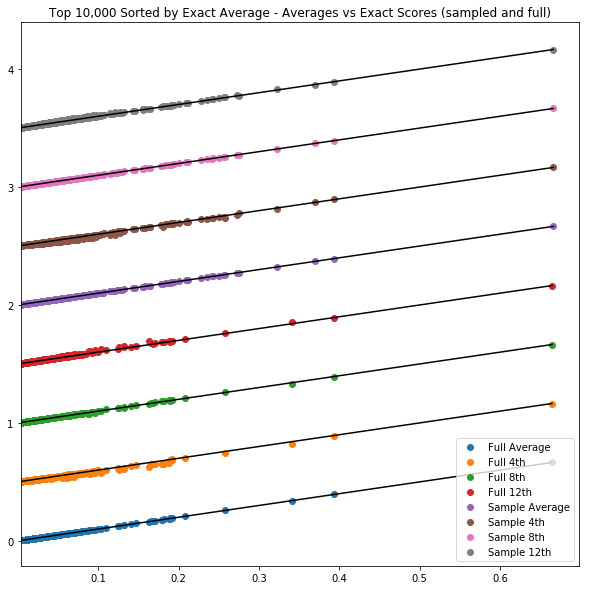

In [421]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.sort_values(by='Average',ascending=True).tail(10000)[:-1]
offset = 0.5
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average'],c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['4']+1*offset,label='Full 4th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+1*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['8']+2*offset,label='Full 8th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+2*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['12']+3*offset,label='Full 12th')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+3*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,label='Sample Average')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s4']+5*offset,label='Sample 4th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+5*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s8']+6*offset,label='Sample 8th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+6*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s12']+7*offset,label='Sample 12th')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+7*offset,c='black')
ax1.set_title('Top 10,000 Sorted by Exact Average - Averages vs Exact Scores (sampled and full)')
ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[8:],labels[8:])
plt.show()

Sampling inflates scores (later shown to be a result of looking at furuther neighbors)

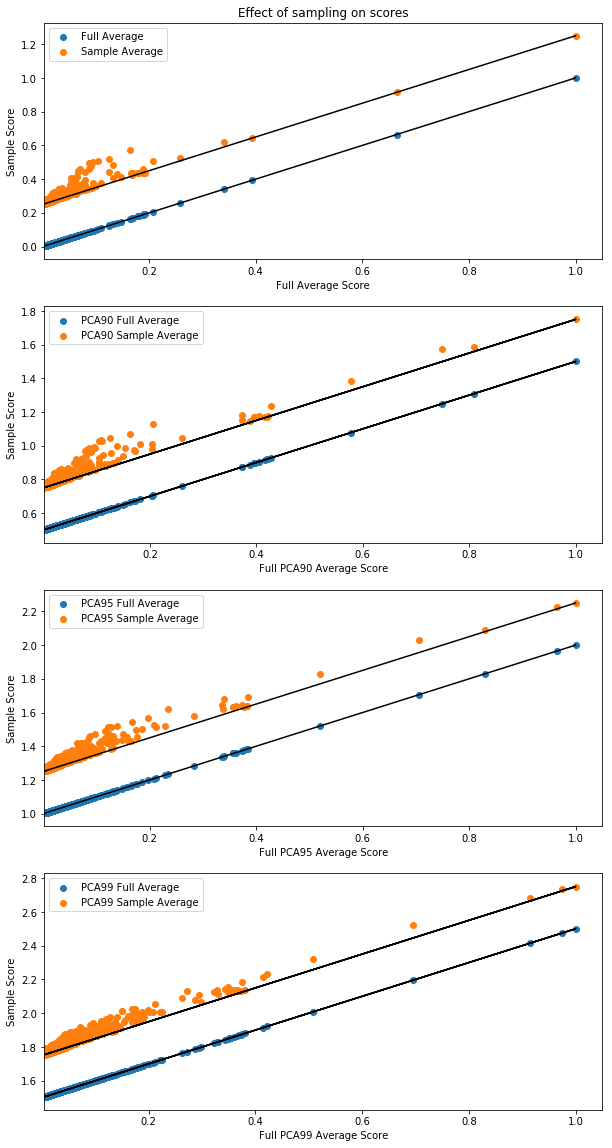

In [418]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.sort_values(by='Average',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(411)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average'],label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average'],c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['sAverage']+.25,label='Sample Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+.25,c='black')
ax1.set_xlabel('Full Average Score')
ax1.set_ylabel('Sample Score')
handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[2:],labels[2:])

ax2 = fig.add_subplot(412)
ax2.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+.5,label='PCA90 Full Average')
ax2.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+.5,c='black')
ax2.scatter(scores_sorted['PCA90_Average'],scores_sorted['PCA90_sAverage']+.75,label='PCA90 Sample Average')
ax2.plot(scores_sorted['PCA90_Average'],scores_sorted['PCA90_Average']+.75,c='black')
ax2.set_xlabel('Full PCA90 Average Score')
ax2.set_ylabel('Sample Score')
handles,labels=ax2.get_legend_handles_labels()
ax2.legend(handles[2:],labels[2:])

ax3 = fig.add_subplot(413)
ax3.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+1,label='PCA95 Full Average')
ax3.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+1,c='black')
ax3.scatter(scores_sorted['PCA95_Average'],scores_sorted['PCA95_sAverage']+1.25,label='PCA95 Sample Average')
ax3.plot(scores_sorted['PCA95_Average'],scores_sorted['PCA95_Average']+1.25,c='black')
ax3.set_xlabel('Full PCA95 Average Score')
ax3.set_ylabel('Sample Score')
handles,labels=ax3.get_legend_handles_labels()
ax3.legend(handles[2:],labels[2:])

ax4 = fig.add_subplot(414)
ax4.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+1.5,label='PCA99 Full Average')
ax4.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+1.5,c='black')
ax4.scatter(scores_sorted['PCA99_Average'],scores_sorted['PCA99_sAverage']+1.75,label='PCA99 Sample Average')
ax4.plot(scores_sorted['PCA99_Average'],scores_sorted['PCA99_Average']+1.75,c='black')
ax4.set_xlabel('Full PCA99 Average Score')
ax4.set_ylabel('Sample Score')
handles,labels=ax4.get_legend_handles_labels()
ax4.legend(handles[2:],labels[2:])

ax1.set_title('Effect of sampling on scores')
ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
ax2.set_xlim((scores_sorted['PCA90_Average'].min(),1.05*scores_sorted['PCA90_Average'].max()))
ax3.set_xlim((scores_sorted['PCA95_Average'].min(),1.05*scores_sorted['PCA95_Average'].max()))
ax4.set_xlim((scores_sorted['PCA99_Average'].min(),1.05*scores_sorted['PCA99_Average'].max()))
plt.show()

Nearest neighbors fluctuate much more than furhter neighbors.

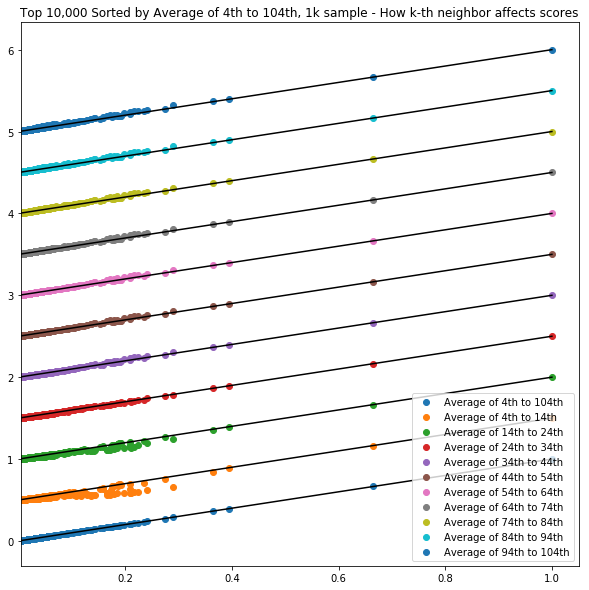

In [408]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.sort_values(by='av_4_104',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_104'],label='Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104'],c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_14']+1*offset,label='Average of 4th to 14th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+1*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_14_24']+2*offset,label='Average of 14th to 24th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+2*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_24_34']+3*offset,label='Average of 24th to 34th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+3*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_34_44']+4*offset,label='Average of 34th to 44th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+4*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_44_54']+5*offset,label='Average of 44th to 54th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+5*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_54_64']+6*offset,label='Average of 54th to 64th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+6*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_64_74']+7*offset,label='Average of 64th to 74th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+7*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_74_84']+8*offset,label='Average of 74th to 84th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+8*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_84_94']+9*offset,label='Average of 84th to 94th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+9*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_94_10']+10*offset,label='Average of 94th to 104th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+10*offset,c='black')

ax1.set_title('Top 10,000 Sorted by Average of 4th to 104th, 1k sample - How k-th neighbor affects scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[11:],labels[11:])

plt.show()

Further neighbors produce similar results (beyond 300th neighbor), which aren't dramitically differnt from closer neighbors

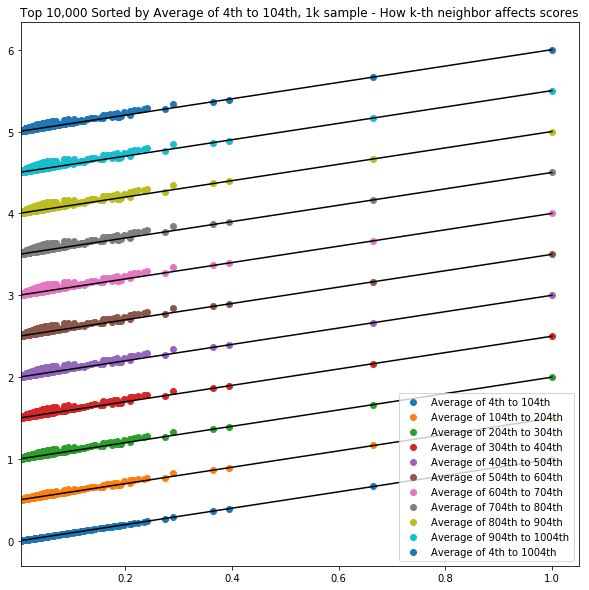

In [406]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.sort_values(by='av_4_104',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_104'],label='Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104'],c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_104_204']+1*offset,label='Average of 104th to 204th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+1*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_204_304']+2*offset,label='Average of 204th to 304th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+2*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_304_404']+3*offset,label='Average of 304th to 404th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+3*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_404_504']+4*offset,label='Average of 404th to 504th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+4*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_504_604']+5*offset,label='Average of 504th to 604th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+5*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_604_704']+6*offset,label='Average of 604th to 704th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+6*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_704_804']+7*offset,label='Average of 704th to 804th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+7*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_804_904']+8*offset,label='Average of 804th to 904th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+8*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_904_1004']+9*offset,label='Average of 904th to 1004th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+9*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_1004']+10*offset,label='Average of 4th to 1004th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+10*offset,c='black')

ax1.set_title('Top 10,000 Sorted by Average of 4th to 104th, 1k sample - How k-th neighbor affects scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[11:],labels[11:])
plt.show()

Sampled data resembles high neighbors (as should be expected). Sampling 1k neighbors decreases density by a factor of ~150. The distance to the 4th nearest neighbor in the sample represents the distance to ~600th nearest neighbor in the full dataset.

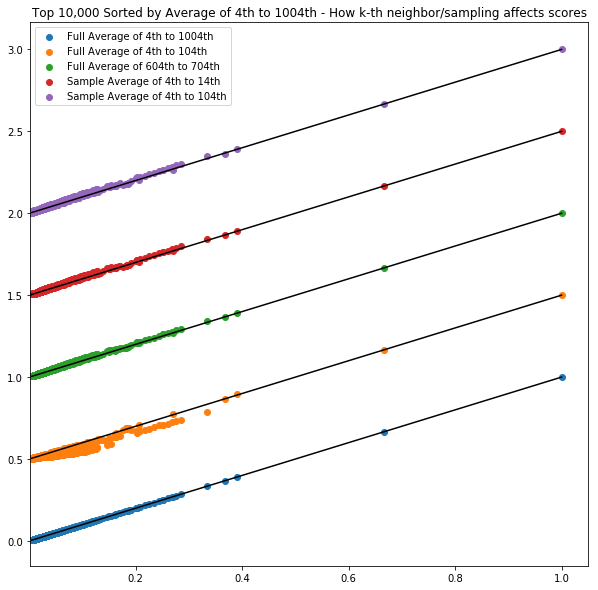

In [422]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.sort_values(by='av_4_1004',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_4_1004'],label='Full Average of 4th to 1004th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004'],c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_4_104']+1*offset,label='Full Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+1*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_604_704']+2*offset,label='Full Average of 604th to 704th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+2*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_s4_14']+3*offset,label='Sample Average of 4th to 14th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+3*offset,c='black')
ax1.scatter(scores_sorted['av_4_1004'],scores_sorted['av_s4_104']+4*offset,label='Sample Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_1004'],scores_sorted['av_4_1004']+4*offset,c='black')



ax1.set_title('Top 10,000 Sorted by Average of 4th to 1004th - How k-th neighbor/sampling affects scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[5:],labels[5:])
plt.show()

For sampled data, increasing the number of neighbors has essentially no effect on scores.

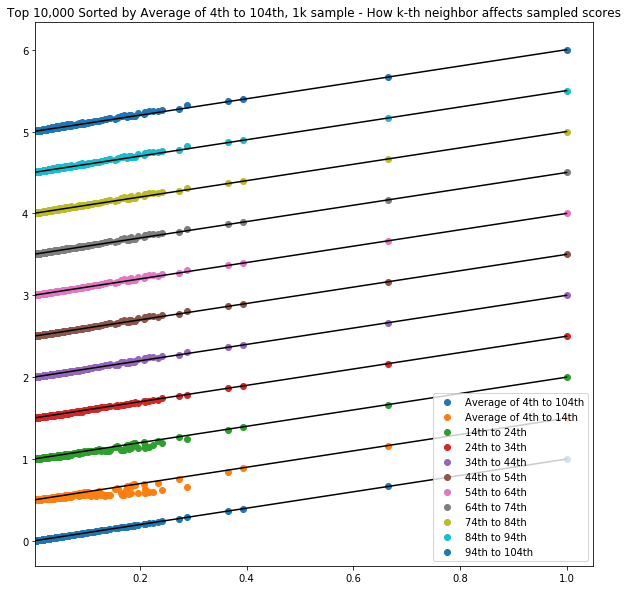

In [425]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.sort_values(by='av_4_104',ascending=True).tail(10000)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_104'],label='Average of 4th to 104th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104'],c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_4_14']+1*offset,label='Average of 4th to 14th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+1*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_14_24']+2*offset,label='14th to 24th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+2*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_24_34']+3*offset,label='24th to 34th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+3*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_34_44']+4*offset,label='34th to 44th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+4*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_44_54']+5*offset,label='44th to 54th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+5*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_54_64']+6*offset,label='54th to 64th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+6*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_64_74']+7*offset,label='64th to 74th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+7*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_74_84']+8*offset,label='74th to 84th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+8*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_84_94']+9*offset,label='84th to 94th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+9*offset,c='black')
ax1.scatter(scores_sorted['av_4_104'],scores_sorted['av_94_10']+10*offset,label='94th to 104th')
ax1.plot(scores_sorted['av_4_104'],scores_sorted['av_4_104']+10*offset,c='black')

ax1.set_title('Top 10,000 Sorted by Average of 4th to 104th, 1k sample - How k-th neighbor affects sampled scores')
ax1.set_xlim((scores_sorted['av_4_104'].min(),1.05*scores_sorted['av_4_104'].max()))
handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[11:],labels[11:])
plt.show()

#### PCA Increases scores, affecting middle scores the most

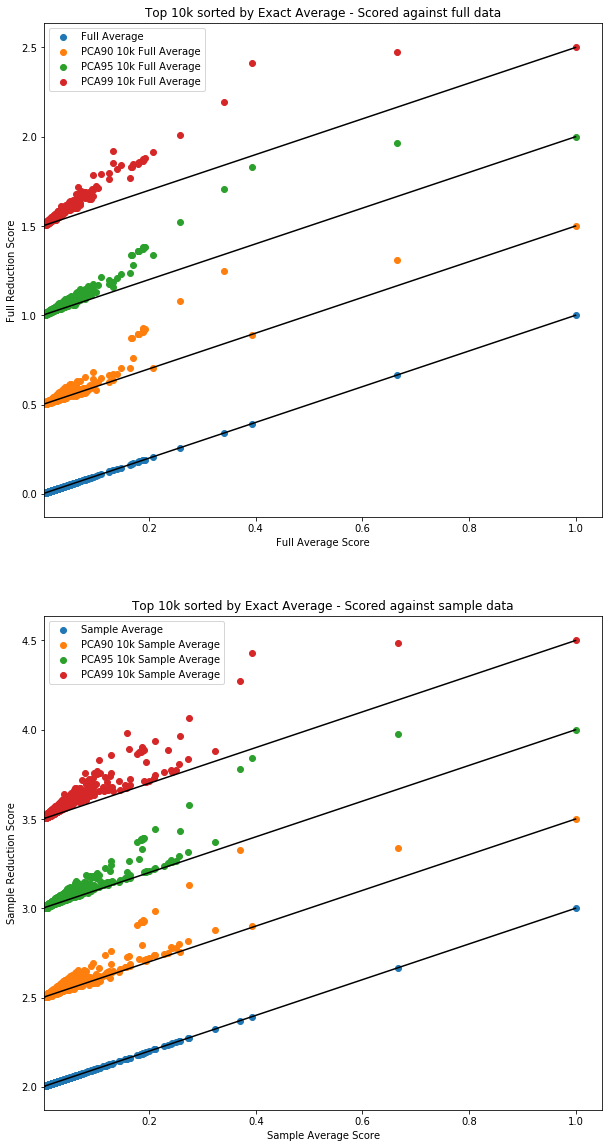

In [427]:
scores_sorted = Q_dict['Q1'].scores.sort_values(by='Average',ascending=True).tail(10000)
offset=1/2
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(211)
ax1.scatter(scores_sorted['Average'],scores_sorted['Average']+0*offset,label='Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+0*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['PCA90_Average']+1*offset,label='PCA90 10k Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+1*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['PCA95_Average']+2*offset,label='PCA95 10k Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+2*offset,c='black')
ax1.scatter(scores_sorted['Average'],scores_sorted['PCA99_Average']+3*offset,label='PCA99 10k Full Average')
ax1.plot(scores_sorted['Average'],scores_sorted['Average']+3*offset,c='black')
ax1.set_title('Top 10k sorted by Exact Average - Scored against full data')
ax1.set_xlabel('Full Average Score')
ax1.set_ylabel('Full Reduction Score')

ax2 = fig.add_subplot(212)
ax2.scatter(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,label='Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+4*offset,c='black')
ax2.scatter(scores_sorted['sAverage'],scores_sorted['PCA90_sAverage']+5*offset,label='PCA90 10k Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+5*offset,c='black')
ax2.scatter(scores_sorted['sAverage'],scores_sorted['PCA95_sAverage']+6*offset,label='PCA95 10k Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+6*offset,c='black')
ax2.scatter(scores_sorted['sAverage'],scores_sorted['PCA99_sAverage']+7*offset,label='PCA99 10k Sample Average')
ax2.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+7*offset,c='black')
ax2.set_title('Top 10k sorted by Exact Average - Scored against sample data')
ax2.set_xlabel('Sample Average Score')
ax2.set_ylabel('Sample Reduction Score')

ax1.set_xlim((scores_sorted['Average'].min(),1.05*scores_sorted['Average'].max()))
ax2.set_xlim((scores_sorted['sAverage'].min(),1.05*scores_sorted['sAverage'].max()))

handles,labels=ax1.get_legend_handles_labels()
ax1.legend(handles[4:],labels[4:])
handles,labels=ax2.get_legend_handles_labels()
ax2.legend(handles[4:],labels[4:])
plt.show()

Size of sample and number of iterations don't affect scoring much.

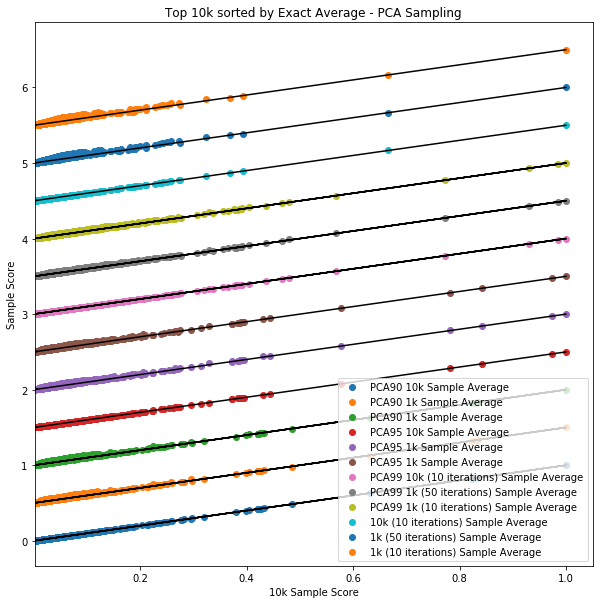

In [426]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.sort_values(by='Average',ascending=True).tail(10000)
plotby = 'PCA90_sAverage'
offset=1/2
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+0*offset,label='PCA90 10k Sample Average')
ax1.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+0*offset,c='black')
ax1.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_s2Average']+1*offset,label='PCA90 1k Sample Average')
ax1.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+1*offset,c='black')
ax1.scatter(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_s3Average']+2*offset,label='PCA90 1k Sample Average')
ax1.plot(scores_sorted['PCA90_sAverage'],scores_sorted['PCA90_sAverage']+2*offset,c='black')
ax1.scatter(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+3*offset,label='PCA95 10k Sample Average')
ax1.plot(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+3*offset,c='black')
ax1.scatter(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_s2Average']+4*offset,label='PCA95 1k Sample Average')
ax1.plot(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+4*offset,c='black')
ax1.scatter(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_s3Average']+5*offset,label='PCA95 1k Sample Average')
ax1.plot(scores_sorted['PCA95_sAverage'],scores_sorted['PCA95_sAverage']+5*offset,c='black')
ax1.scatter(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+6*offset,label='PCA99 10k (10 iterations) Sample Average')
ax1.plot(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+6*offset,c='black')
ax1.scatter(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_s2Average']+7*offset,label='PCA99 1k (50 iterations) Sample Average')
ax1.plot(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+7*offset,c='black')
ax1.scatter(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_s3Average']+8*offset,label='PCA99 1k (10 iterations) Sample Average')
ax1.plot(scores_sorted['PCA99_sAverage'],scores_sorted['PCA99_sAverage']+8*offset,c='black')

ax1.scatter(scores_sorted['sAverage'],scores_sorted['sAverage']+9*offset,label='10k (10 iterations) Sample Average')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+9*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s2Average']+10*offset,label='1k (50 iterations) Sample Average')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+10*offset,c='black')
ax1.scatter(scores_sorted['sAverage'],scores_sorted['s3Average']+11*offset,label='1k (10 iterations) Sample Average')
ax1.plot(scores_sorted['sAverage'],scores_sorted['sAverage']+11*offset,c='black')

ax1.set_title('Top 10k sorted by Exact Average - PCA Sampling')
ax1.set_xlabel('10k Sample Score')
ax1.set_ylabel('Sample Score')
ax1.set_xlim((scores_sorted[plotby].min(),1.05*scores_sorted[plotby].max()))

handles,labels=ax1.get_legend_handles_labels()
plt.legend(handles[12:],labels[12:])
plt.show()

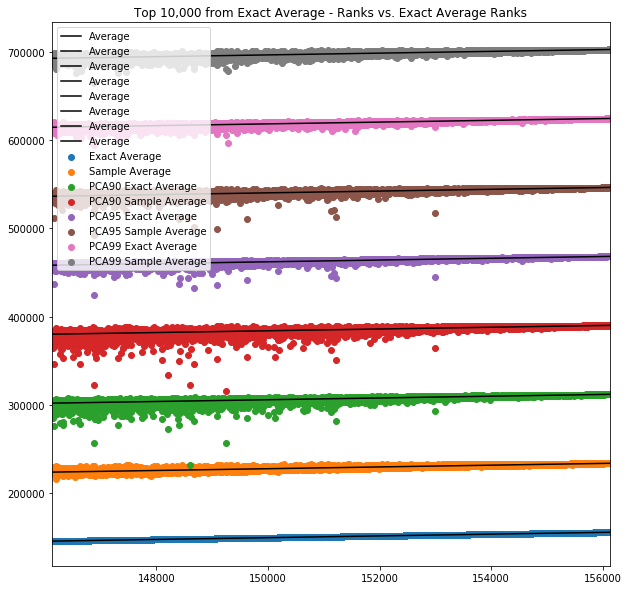

In [323]:
%matplotlib inline
scores_sorted = Q_dict['Q1'].scores.rank(ascending=True).sort_values(by='Average').tail(10000)
plotby = 'Average'
offset=len(Q_dict['Q1'].scores)/2
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(scores_sorted[plotby],scores_sorted['Average'],label='Exact Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby],c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['sAverage']+1*offset,label='Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+1*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA90_Average']+2*offset,label='PCA90 Exact Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+2*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA90_sAverage']+3*offset,label='PCA90 Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+3*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA95_Average']+4*offset,label='PCA95 Exact Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+4*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA95_sAverage']+5*offset,label='PCA95 Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+5*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA99_Average']+6*offset,label='PCA99 Exact Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+6*offset,c='black')
ax1.scatter(scores_sorted[plotby],scores_sorted['PCA99_sAverage']+7*offset,label='PCA99 Sample Average')
ax1.plot(scores_sorted[plotby],scores_sorted[plotby]+7*offset,c='black')
ax1.set_title('Top 10,000 from Exact Average - Ranks vs. Exact Average Ranks')
ax1.set_xlim((scores_sorted[plotby].min(),scores_sorted[plotby].max()))
plt.legend()
plt.show()

In [433]:
Q_dict.keys()
for Q_key in list(Q_dict.keys())[1:]:
    print(Q_key,Q_dict[Q_key].scores.columns)

Q2 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 'sAverage'],
      dtype='object')
Q3 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 'sAverage'],
      dtype='object')
Q4 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 'sAverage'],
      dtype='object')
Q5 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 'sAverage'],
      dtype='object')
Q6 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 'sAverage'],
      dtype='object')
Q7 Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'Average', 's4',
       's5', '

In [428]:
for Q_key in list(Q_dict.keys())[1:]:
    for red_key in Q_dict[Q_key].reductions.keys():
        print("Scoring {}".format(Q_key))
        starttime = datetime.now()
        Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
        Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
        columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_Average'.format(red_key))
        scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
        Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
        columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_sAverage'.format(red_key))
        scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Total time to score: {}".format(datetime.now()-starttime))
        for col in scoresdf_s.columns:
            scoresdf[col]=scoresdf_s[col]

        for col in scoresdf.columns:
            Q_dict[Q_key].scores[col]=scoresdf[col]
    Q_dict[Q_key].save()

Scoring Q17
Time to score exact neighbors: 0:10:17.582007
Total time to score: 0:20:54.485173
Scoring Q17
Time to score exact neighbors: 0:13:45.609425
Total time to score: 0:25:11.313522
Scoring Q17
Time to score exact neighbors: 0:14:33.155532
Total time to score: 0:25:47.863622


"""
Exact kNN scores produced for all quarters.
"""
```
for k in Q_dict.keys():
    print("Starting {}".format(k))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[k].data)
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
    
    columns=['{}'.format(i) for i in range(4,14)]
    columns.append('Average')
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
    
    exacttime = datetime.now()
    print("time to calculate exact scores: {}".format(exacttime-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
    
    columns=['s{}'.format(i) for i in range(4,14)]
    columns.append('sAverage')
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)

    sampletime = datetime.now()
    print("time to calculate sample scores: {}".format(sampletime-starttime))
    
    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]
    
    Q_dict[k].scores = scoresdf
    Q_dict[k].save()
```

|Quarter|time to calc exact scores|total time (exact+sample)|
|-------|-------------------------|-------------------------|
|Q1|12:35.76|22:15.23|
|Q2|12:34.39|23:08.03|
|Q3|05:27.76|12:39.33|
|Q4|17:11.87|29:15.34|
|Q5|14:49.00|25:35.21|
|Q6|16:32.17|27:19.16|
|Q7|14:55.92|25:31.84|
|Q8|20:23.49|31:40.92|
|Q9|10:00.81|22:04.77|
|Q10|12:39.31|22:34.53|
|Q11|16:24.55|27:25.22|
|Q12|15:11.95|26:40.49|
|Q13|09:38.58|20:21.77|
|Q14|15:38.77|27:21.49|
|Q15|15:34.69|29:05.41|
|Q16|17:16.13|28:47.02|
|Q17|16:59.16|27:53.98|


In [198]:
Q_dict['Q2'].reductions.keys()

dict_keys([])

In [952]:
def compare_ranks(compdf2,ft1,ft2):
    sorted_abs = abs(compdf2.sort_values(ft1,ascending=False))
    
    md_hd = lambda h: sorted_abs.head(h)[ft2].median()
    mn_hd = lambda h: sorted_abs.head(h)[ft2].mean()
    sd_hd = lambda h: sorted_abs.head(h)[ft2].std()
    
    md_tl = lambda h: sorted_abs.tail(h)[ft2].median()
    mn_tl = lambda h: sorted_abs.tail(h)[ft2].mean()
    sd_tl = lambda h: sorted_abs.tail(h)[ft2].std()

    print("""
    10:
      Median head diff: {:5.1f}, Mean head diff: {:5.1f}, Standard Deviation: {:5.1f}
      Median tail diff: {:5.1f}, Mean tail diff: {:5.1f}, Standard Deviation: {:5.1f}

    1h:
      Median head diff: {:5.1f}, Mean head diff: {:5.1f}, Standard Deviation: {:5.1f}
      Median tail diff: {:5.1f}, Mean tail diff: {:5.1f}, Standard Deviation: {:5.1f}

    1k:
      Median head diff: {:5.1f}, Mean head diff: {:5.1f}, Standard Deviation: {:5.1f}
      Median tail diff: {:5.1f}, Mean tail diff: {:5.1f}, Standard Deviation: {:5.1f}

    10k:
      Median head diff: {:5.1f}, Mean head diff: {:5.1f}, Standard Deviation: {:5.1f}
      Median tail diff: {:5.1f}, Mean tail diff: {:5.1f}, Standard Deviation: {:5.1f}
      
    Full:
      Median diff: {:6.1f}, Mean diff: {:6.1f}, Standard Deviation: {:6.1f}
    """.format(md_hd(10),mn_hd(10),sd_hd(10),
               md_tl(10),mn_tl(10),sd_tl(10),
               md_hd(100),mn_hd(100),sd_hd(100),
               md_tl(100),mn_tl(100),sd_tl(100),
               md_hd(1000),mn_hd(1000),sd_hd(1000),
               md_tl(1000),mn_tl(1000),sd_tl(1000),
               md_hd(10000),mn_hd(10000),sd_hd(10000),
               md_tl(10000),mn_tl(10000),sd_tl(10000),
               sorted_abs[ft2].median(),sorted_abs[ft2].mean(),sorted_abs[ft2].std())
         )
    return

In [791]:
def timetest(QN,n_sample,k_neighbors):
    #startTime = datetime.now()
    data = QN.data
    dims = 0
    for col in data.columns:    
        if col == 'db_out':
            break
        else:
            dims+=1
    #print("Scoring {} in {} dimensions".format(Q,dims))
    scaled_data = dataScaler(data,dims)
    ref_data_sample = scaled_data.sample(n=n_sample)
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree',n_jobs=-1).fit(ref_data_sample)
    distances, indices = nbrs.kneighbors(scaled_data)
    dist_avgs = np.mean(distances[:,1:],axis=1)
    #print("Time to process: {}".format(datetime.now()-startTime))
    return dist_avgs


In [ ]:
comp = data.loc[:,['dist_score']]

# MinMaxScaler operates on data points, i.e. it assumes each index refers to a single data point 
# as a collection of features.
# For 1 dimensional data (a list of a singular metric), the data must be reshaped so that it's an array of
# 1D data points for processing, then can be reshaped back to the original form (which isn't strictly necessary)
tmp_scores_scaled = list(preprocessing.MinMaxScaler().fit_transform(X=tmp_scores.reshape(-1,1)).reshape(1,-1)[0])
comp['samp_score'] = tmp_scores_scaled
comp['rank_diff'] = comp.rank(ascending=False).dist_score-comp.rank(ascending=False).samp_score

In [553]:
tmp_dist = tmp_scores.copy()
tmp_dist.sort()

In [556]:
number = int(np.ceil(len(tmp_dist)/500))
cutoff = 1.05
for i in range(int(np.ceil(len(tmp_dist)/2)),len(tmp_dist)-number):
    if np.mean(tmp_dist[i+1:i+number])>=cutoff*np.mean(tmp_dist[i-number:i-1]):
        dbEps = tmp_dist[i]
        pt = i
        break
print(dbEps)
d = {True:-1,False:0}
tmp_clusterLabels = np.array([d[pt>dbEps] for pt in tmp_dist]) 
tmp_comp_labels = Q4_pca90.data.db_out
tmp_comp_labels = np.array([d[i!=0] for i in tmp_comp_labels])


0.00730854527945


In [792]:
Q = Q4_pca90
data = Q.data
comp = data.loc[:,['dist_score']]
n_iter = 5

for i in range(n_iter):
    tmp_scores = timetest(Q,n_sample=10000) # distance to 4th neighbor as score
    # MinMaxScaler assumes each index refers to a single data point as a collection of features.
    # Singular features need reshaped to an array of 1D data points for processing, then can be reshaped to the original form (not strictly necessary)
    tmp_scores_scaled = preprocessing.MinMaxScaler().fit_transform(X=tmp_scores.reshape(-1,1)).reshape(1,-1)[0]
    if i==0: tmp_scores_arr = tmp_scores_scaled
    if i>0:
        tmp_scores_arr = np.vstack([tmp_scores_arr,tmp_scores_scaled]) # Putting all scores in one place
        tmp_scores_new = np.mean(tmp_scores_arr,axis=0) # calculating new average scores
        tmp_scores_old = np.mean(tmp_scores_arr[:-1,:],axis=0) # calculating average scores for previous iteration
        mean_diff = np.mean(tmp_scores_new-tmp_scores_old) # comparing difference in overall scores
        print(mean_diff) # printing to see if there's improvement

tmp_scores = tmp_scores_new
comp['samp_score'] = tmp_scores
comp['score_diff'] = abs(comp.dist_score-comp.samp_score)
comp['rank_diff'] = comp.rank(ascending=False).dist_score-comp.rank(ascending=False).samp_score

1.52825959791e-05
1.13243168141e-05
-3.89653054764e-06
1.03957550366e-05


In [832]:
def timetest_mod1(QN,k_neighbors):
    # Mod 1 uses no sampling, the score is calculated based on the entire dataset and the number of neighbors can be specified.
    startTime = datetime.now()
    data = QN.data
    dims = 0
    for col in data.columns:    
        if col == 'db_out':
            break
        else:
            dims+=1
    scaled_data = dataScaler(data,dims)
    nbrs = NearestNeighbors(n_neighbors=k_neighbors+1, algorithm='ball_tree',n_jobs=-1).fit(scaled_data)
    distances, indices = nbrs.kneighbors(scaled_data)
    print("Time to process: {}".format(datetime.now()-startTime))
    return distances

compdf = pd.DataFrame(columns=['k=%s'%k for k in range(2,101)],index=Q4_pca90.data.index)
distances = timetest_mod1(Q4_pca90,k_neighbors=101)
for k in range(2,100):
    dist_avgs = np.mean(distances[:,1:k],axis=1)
    tmp_scores_scaled = preprocessing.MinMaxScaler().fit_transform(X=dist_avgs.reshape(-1,1)).reshape(1,-1)[0]
    compdf['k=%s'%k]=tmp_scores_scaled
compdf.head(10)

Time to process: 0:07:59.865527


,2k,3k,4k,5k,6k,7k,8k,9k,10k,11k,...,k=90,k=91,k=92,k=93,k=94,k=95,k=96,k=97,k=98,k=99
kplr000757076-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000667,0.000668,0.000669,0.000670,0.000671,0.000672,0.000673,0.000674,0.000675,0.000676
kplr000757099-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010025,0.010033,0.010041,0.010048,0.010056,0.010064,0.010071,0.010078,0.010086,0.010093
kplr000757137-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002552,0.002556,0.002559,0.002563,0.002567,0.002571,0.002574,0.002578,0.002582,0.002585
kplr000757280-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001400,0.001402,0.001405,0.001408,0.001410,0.001413,0.001416,0.001418,0.001421,0.001424
kplr000757450-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004477,0.004480,0.004483,0.004486,0.004489,0.004492,0.004494,0.004497,0.004500,0.004503
kplr000891901-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000600,0.000601,0.000602,0.000602,0.000603,0.000603,0.000604,0.000604,0.000605,0.000606
kplr000891916-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002484,0.002489,0.002494,0.002499,0.002504,0.002510,0.002515,0.002520,0.002524,0.002529
kplr000892107-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000484,0.000485,0.000486,0.000487,0.000488,0.000488,0.000489,0.000490,0.000491,0.000492
kplr000892195-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000443,0.000444,0.000445,0.000445,0.000446,0.000447,0.000448,0.000448,0.000449,0.000450
kplr000892203-2010078095331_llc.fits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000290,0.000290,0.000290,0.000291,0.000291,0.000291,0.000291,0.000291,0.000291,0.000292


In [852]:
compdf.sort_values('k=99',ascending=False).head(10)

,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10,k=11,...,k=90,k=91,k=92,k=93,k=94,k=95,k=96,k=97,k=98,k=99
kplr007691527-2010078095331_llc.fits,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
kplr007679979-2010078095331_llc.fits,0.718037,0.743064,0.756936,0.763523,0.768587,0.772609,0.776942,0.781183,0.786457,0.790666,...,0.835277,0.835385,0.835491,0.835595,0.835697,0.835797,0.835895,0.835991,0.836085,0.836178
kplr007446357-2010078095331_llc.fits,0.527846,0.637121,0.672563,0.690632,0.703503,0.712576,0.720214,0.726790,0.731897,0.736149,...,0.776964,0.777042,0.777118,0.777193,0.777266,0.777338,0.777409,0.777478,0.777547,0.777614
kplr007659570-2010078095331_llc.fits,0.527846,0.574511,0.591985,0.600652,0.607083,0.611168,0.614174,0.616985,0.619403,0.621534,...,0.643732,0.643776,0.643819,0.643861,0.643903,0.643944,0.643984,0.644024,0.644063,0.644102
kplr005772512-2010078095331_llc.fits,0.295893,0.352267,0.379133,0.410970,0.435112,0.451943,0.464399,0.474129,0.482354,0.489093,...,0.558084,0.558220,0.558354,0.558485,0.558613,0.558739,0.558862,0.558982,0.559101,0.559217
kplr009098388-2010078095331_llc.fits,0.138278,0.286021,0.355248,0.389020,0.415167,0.432543,0.444924,0.454779,0.462480,0.469974,...,0.541756,0.541886,0.542014,0.542139,0.542263,0.542384,0.542503,0.542619,0.542733,0.542845
kplr009408009-2010078095331_llc.fits,0.138278,0.219001,0.267174,0.290722,0.310840,0.324264,0.333860,0.341648,0.347750,0.353970,...,0.416102,0.416220,0.416336,0.416450,0.416562,0.416672,0.416781,0.416886,0.416990,0.417092
kplr003440230-2010078095331_llc.fits,0.152389,0.150107,0.174357,0.197658,0.211745,0.223975,0.234822,0.243191,0.249860,0.257180,...,0.377554,0.377888,0.378214,0.378534,0.378847,0.379154,0.379455,0.379751,0.380043,0.380329
kplr007033135-2010078095331_llc.fits,0.312670,0.313398,0.315479,0.320216,0.324312,0.327155,0.330165,0.332652,0.334566,0.336138,...,0.374371,0.374555,0.374736,0.374915,0.375093,0.375266,0.375436,0.375605,0.375772,0.375936
kplr007950964-2010078095331_llc.fits,0.322534,0.320274,0.320051,0.320229,0.320938,0.321397,0.322251,0.323022,0.323793,0.324450,...,0.350364,0.350545,0.350724,0.350901,0.351074,0.351248,0.351419,0.351586,0.351752,0.351918


In [895]:
compdf_exact = pd.DataFrame(columns=['k=%s'%k for k in range(2,101)],index=Q4_pca90.data.index)
for k in range(2,101):
    dist_avgs = distances[:,k]
    tmp_scores_scaled = preprocessing.MinMaxScaler().fit_transform(X=dist_avgs.reshape(-1,1)).reshape(1,-1)[0]
    compdf_exact['k=%s'%k]=tmp_scores_scaled
compdf_exact.rank(ascending=False).sort_values('k=60').head(10)

,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10,k=11,...,k=91,k=92,k=93,k=94,k=95,k=96,k=97,k=98,k=99,k=100
kplr007691527-2010078095331_llc.fits,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
kplr007679979-2010078095331_llc.fits,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
kplr007446357-2010078095331_llc.fits,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
kplr007659570-2010078095331_llc.fits,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
kplr005772512-2010078095331_llc.fits,6.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
kplr009098388-2010078095331_llc.fits,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
kplr009408009-2010078095331_llc.fits,9.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
kplr003440230-2010078095331_llc.fits,16.0,13.0,10.0,10.0,11.0,10.0,10.0,10.0,10.0,10.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
kplr007033135-2010078095331_llc.fits,8.0,9.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
kplr007950964-2010078095331_llc.fits,7.0,8.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [955]:
compdf_rank = compdf.rank(ascending=False)
compdf['rank_sd'] = [compdf_rank.iloc[i,:].std() for i in range(len(compdf_rank))]
compdf['sd_2_50'] = [compdf_rank.iloc[i,:49].std() for i in range(len(compdf_rank))]
compdf['sd_51_99'] = [compdf_rank.iloc[i,50:].std() for i in range(len(compdf_rank))]

In [961]:
compare_ranks(compdf,'k=60','rank_sd')


    10:
      Median head diff:   0.3, Mean head diff:   0.4, Standard Deviation:   0.3
      Median tail diff: 100.0, Mean tail diff: 175.9, Standard Deviation: 157.2

    1h:
      Median head diff:   8.4, Mean head diff:  27.6, Standard Deviation:  64.9
      Median tail diff: 177.5, Mean tail diff: 221.8, Standard Deviation: 197.8

    1k:
      Median head diff:  50.5, Mean head diff:  84.7, Standard Deviation: 114.6
      Median tail diff: 359.6, Mean tail diff: 529.8, Standard Deviation: 482.4

    10k:
      Median head diff: 240.9, Mean head diff: 390.5, Standard Deviation: 543.4
      Median tail diff: 1073.6, Mean tail diff: 1312.1, Standard Deviation: 941.4
      
    Full:
      Median diff: 1934.4, Mean diff: 2359.7, Standard Deviation: 1815.9
    


In [962]:
compare_ranks(compdf,'k=60','sd_2_50')


    10:
      Median head diff:   0.3, Mean head diff:   0.4, Standard Deviation:   0.4
      Median tail diff: 141.0, Mean tail diff: 245.4, Standard Deviation: 218.7

    1h:
      Median head diff:   9.3, Mean head diff:  35.5, Standard Deviation:  91.4
      Median tail diff: 238.0, Mean tail diff: 303.3, Standard Deviation: 273.3

    1k:
      Median head diff:  47.3, Mean head diff:  88.9, Standard Deviation: 143.4
      Median tail diff: 470.1, Mean tail diff: 688.5, Standard Deviation: 644.4

    10k:
      Median head diff: 244.7, Mean head diff: 416.5, Standard Deviation: 660.2
      Median tail diff: 1257.7, Mean tail diff: 1563.6, Standard Deviation: 1168.8
      
    Full:
      Median diff: 2124.7, Mean diff: 2634.2, Standard Deviation: 2097.9
    


In [963]:
compare_ranks(compdf,'k=60','sd_51_99')


    10:
      Median head diff:   0.0, Mean head diff:   0.1, Standard Deviation:   0.2
      Median tail diff:   0.7, Mean tail diff:   1.4, Standard Deviation:   2.3

    1h:
      Median head diff:   0.8, Mean head diff:   1.1, Standard Deviation:   1.0
      Median tail diff:   4.4, Mean tail diff:   6.6, Standard Deviation:   6.5

    1k:
      Median head diff:   9.9, Mean head diff:  15.1, Standard Deviation:  16.5
      Median tail diff:  24.6, Mean tail diff:  33.7, Standard Deviation:  31.4

    10k:
      Median head diff:  43.0, Mean head diff:  67.1, Standard Deviation:  74.1
      Median tail diff: 112.9, Mean tail diff: 157.5, Standard Deviation: 142.4
      
    Full:
      Median diff:  270.1, Mean diff:  366.9, Standard Deviation:  336.2
    


In [905]:
compdf_exact_rank = compdf_exact.rank(ascending=False)

In [927]:
compdf_exact['std_dev']=[compdf_exact_rank.iloc[i,:].std() for i in range(len(compdf_exact_rank))]

In [936]:
compare_ranks(compdf_exact,'k=60','std_dev')


    10:
      Median head diff:   0.1, Mean head diff:   0.2, Standard Deviation:   0.3
      Median tail diff:  46.4, Mean tail diff:  87.9, Standard Deviation:  93.7

    1h:
      Median head diff:   7.3, Mean head diff:  10.6, Standard Deviation:  11.8
      Median tail diff: 132.9, Mean tail diff: 178.4, Standard Deviation: 169.5

    1k:
      Median head diff:  56.8, Mean head diff:  86.6, Standard Deviation:  95.9
      Median tail diff: 311.2, Mean tail diff: 411.2, Standard Deviation: 312.6

    10k:
      Median head diff: 256.1, Mean head diff: 394.5, Standard Deviation: 510.4
      Median tail diff: 1097.2, Mean tail diff: 1209.9, Standard Deviation: 700.1
    


In [ ]:
# Has been run, but output cleared bc of seperate errors (which don't affect what remains in this cell)
compdf_exact['sd_2_50'] = [compdf_exact_rank.iloc[i,:49].std() for i in range(len(compdf_exact_rank))]

In [954]:
compare_ranks(compdf_exact,'k=60','sd_2_50')


    10:
      Median head diff:   0.2, Mean head diff:   0.3, Standard Deviation:   0.5
      Median tail diff:  62.7, Mean tail diff: 121.4, Standard Deviation: 130.8

    1h:
      Median head diff:   8.4, Mean head diff:  13.3, Standard Deviation:  15.8
      Median tail diff: 168.4, Mean tail diff: 235.6, Standard Deviation: 232.5

    1k:
      Median head diff:  53.1, Mean head diff:  86.5, Standard Deviation: 104.5
      Median tail diff: 385.9, Mean tail diff: 519.7, Standard Deviation: 411.3

    10k:
      Median head diff: 260.9, Mean head diff: 405.3, Standard Deviation: 563.4
      Median tail diff: 1291.2, Mean tail diff: 1436.3, Standard Deviation: 846.8
      
    Full:
      Median diff: 2308.1, Mean diff: 2575.6, Standard Deviation: 1691.0
    


In [ ]:
# Cell run, output suppressed because of unrelated errors.
compdf_exact['sd_51_100'] = [compdf_exact_rank.iloc[i,50:99].std() for i in range(len(compdf_exact_rank))]

In [953]:
compare_ranks(compdf_exact,'k=60','sd_51_100')


    10:
      Median head diff:   0.0, Mean head diff:   0.0, Standard Deviation:   0.0
      Median tail diff:   1.7, Mean tail diff:   3.8, Standard Deviation:   4.0

    1h:
      Median head diff:   0.3, Mean head diff:   0.4, Standard Deviation:   0.6
      Median tail diff:  11.8, Mean tail diff:  15.2, Standard Deviation:  12.3

    1k:
      Median head diff:  14.6, Mean head diff:  19.9, Standard Deviation:  18.6
      Median tail diff:  65.9, Mean tail diff:  77.6, Standard Deviation:  57.8

    10k:
      Median head diff:  63.9, Mean head diff:  88.9, Standard Deviation:  83.5
      Median tail diff: 295.8, Mean tail diff: 333.6, Standard Deviation: 215.0
      
    Full:
      Median diff:  533.5, Mean diff:  614.8, Standard Deviation:  426.6
    


In [816]:
#comp['samp_score'] = tmp_scores

comp_dist_scores = tmp_scores_scaled
comp['dist_score'] = comp_dist_scores
comp['score_diff'] = abs(comp.dist_score-comp.samp_score)
comp['rank_diff'] = comp.rank(ascending=False).dist_score-comp.rank(ascending=False).samp_score

In [817]:
# Comparing the exact dist score for the 59th neighbor to the average dist score for the 1st-59th neighbors
comp['exact_dist_score']=Q4_pca90.data.loc[:,['dist_score']].as_matrix()
comp['av_v_ex_score_diff']=abs(comp.dist_score-comp.exact_dist_score)
comp['av_v_ex_rank_diff']=comp.rank(ascending=False).dist_score-comp.rank(ascending=False).exact_dist_score

In [818]:
comp.sort_values('exact_dist_score',ascending=False).head(10)

,dist_score,samp_score,score_diff,rank_diff,exact_dist_score,av_v_ex_score_diff,av_v_ex_rank_diff
kplr007691527-2010078095331_llc.fits,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.0
kplr007679979-2010078095331_llc.fits,0.830811,0.844093,0.013282,0.0,0.843297,0.012486,0.0
kplr007446357-2010078095331_llc.fits,0.773618,0.783213,0.009595,0.0,0.783049,0.009431,0.0
kplr007659570-2010078095331_llc.fits,0.641818,0.647322,0.005504,0.0,0.647217,0.005399,0.0
kplr005772512-2010078095331_llc.fits,0.552016,0.568608,0.016592,0.0,0.569547,0.017531,0.0
kplr009098388-2010078095331_llc.fits,0.535931,0.552073,0.016142,0.0,0.552533,0.016601,0.0
kplr009408009-2010078095331_llc.fits,0.410840,0.425310,0.014470,0.0,0.425760,0.014920,0.0
kplr003440230-2010078095331_llc.fits,0.363162,0.402263,0.039101,1.0,0.403101,0.039939,1.0
kplr007033135-2010078095331_llc.fits,0.367054,0.385761,0.018708,-1.0,0.386684,0.019630,-1.0
kplr007950964-2010078095331_llc.fits,0.344071,0.370875,0.026805,0.0,0.359100,0.015029,0.0


In [801]:
comp.sort_values('dist_score',ascending=False).head(10)

,dist_score,samp_score,score_diff,rank_diff
kplr007691527-2010078095331_llc.fits,1.000000,1.000000,0.000000,0.0
kplr007679979-2010078095331_llc.fits,0.844083,0.844093,0.000010,0.0
kplr007446357-2010078095331_llc.fits,0.783199,0.783213,0.000014,0.0
kplr007659570-2010078095331_llc.fits,0.647299,0.647322,0.000023,0.0
kplr005772512-2010078095331_llc.fits,0.568581,0.568608,0.000028,0.0
kplr009098388-2010078095331_llc.fits,0.552044,0.552073,0.000029,0.0
kplr009408009-2010078095331_llc.fits,0.425273,0.425310,0.000037,0.0
kplr003440230-2010078095331_llc.fits,0.402224,0.402263,0.000038,0.0
kplr007033135-2010078095331_llc.fits,0.385722,0.385761,0.000039,0.0
kplr007950964-2010078095331_llc.fits,0.370835,0.370875,0.000040,0.0


In [821]:
ft1 = 'dist_score'
ft2 = 'rank_diff'

mean_10_head = abs(comp.sort_values(ft1,ascending=False).head(10)[ft2]).mean()
med_10_head = abs(comp.sort_values(ft1,ascending=False).head(10)[ft2]).median()
mean_10_tail = abs(comp.sort_values(ft1,ascending=False).tail(10)[ft2]).mean()
med_10_tail = abs(comp.sort_values(ft1,ascending=False).tail(10)[ft2]).median()
mean_1h_head = abs(comp.sort_values(ft1,ascending=False).head(100)[ft2]).mean()
med_1h_head = abs(comp.sort_values(ft1,ascending=False).head(100)[ft2]).median()
mean_1h_tail = abs(comp.sort_values(ft1,ascending=False).tail(100)[ft2]).mean()
med_1h_tail = abs(comp.sort_values(ft1,ascending=False).tail(100)[ft2]).median()
mean_1k_head = abs(comp.sort_values(ft1,ascending=False).head(1000)[ft2]).mean()
med_1k_head = abs(comp.sort_values(ft1,ascending=False).head(1000)[ft2]).median()
mean_1k_tail = abs(comp.sort_values(ft1,ascending=False).tail(1000)[ft2]).mean()
med_1k_tail = abs(comp.sort_values(ft1,ascending=False).tail(1000)[ft2]).median()
mean_10k_head = abs(comp.sort_values(ft1,ascending=False).head(10000)[ft2]).mean()
med_10k_head = abs(comp.sort_values(ft1,ascending=False).head(10000)[ft2]).median()
mean_10k_tail = abs(comp.sort_values(ft1,ascending=False).tail(10000)[ft2]).mean()
med_10k_tail = abs(comp.sort_values(ft1,ascending=False).tail(10000)[ft2]).median()

print("""
10:
  Mean head diff: {:5.1f}, Median head diff: {}
  Mean tail diff: {:5.1f}, Median tail diff: {}

1h:
  Mean head diff: {:5.1f}, Median head diff: {}
  Mean tail diff: {:5.1f}, Median tail diff: {}
  
1k:
  Mean head diff: {:5.1f}, Median head diff: {}
  Mean tail diff: {:5.1f}, Median tail diff: {}
  
10k:
  Mean head diff: {:5.1f}, Median head diff: {}
  Mean tail diff: {:5.1f}, Median tail diff: {}
""".format(mean_10_head,med_10_head,
           mean_10_tail,med_10_tail,
           mean_1h_head,med_1h_head,
           mean_1h_tail,med_1h_tail,
           mean_1k_head,med_1k_head,
           mean_1k_tail,med_1k_tail,
           mean_10k_head,med_10k_head,
           mean_10k_tail,med_10k_tail))


10:
  Mean head diff:   0.2, Median head diff: 0.0
  Mean tail diff:  12.9, Median tail diff: 4.0

1h:
  Mean head diff:   4.8, Median head diff: 3.0
  Mean tail diff:  46.9, Median tail diff: 23.0
  
1k:
  Mean head diff:  59.9, Median head diff: 41.0
  Mean tail diff: 192.7, Median tail diff: 135.5
  
10k:
  Mean head diff: 293.7, Median head diff: 195.0
  Mean tail diff: 812.3, Median tail diff: 585.0



In [209]:
def scoreLoop(qdict,full=False):
    startTime = datetime.now()
    scores_dict = dict()
    for Q in qdict:
        qStartTime = datetime.now()
        print("Starting {}".format(Q))
        QN = qdict[Q]
        data = QN.data
        dims = 0
        for col in data.columns:    
            if col == 'db_out':
                break
            else:
                dims+=1
        print("Scoring {} in {} dimensions".format(Q,dims))
        scaled_data = dataScaler(data,dims)
        if full:
            data_to_score = scaled_data
        else:
            data_to_score = scaled_data[data.db_out==-1] # This verson only scores outliers
        out_scores = dist_score(scaled_data,data_to_score) 
        scores_dict[Q] = out_scores
        print("Time to process {}: {}".format(Q,datetime.now()-qStartTime))

    print("Time to process all quarters: {}".format(datetime.now()-startTime))
    return scores_dict

### Comparing Scores by quarter (Scores for all objects, outlying and otherwise)

Scores have been generated for the baseline and the reductions for each quarter, the time to process has been recorded in the notes in the PCA_Reduction folder. Original cells that processed the full data (rather than just the outliers) have been overwritten by cleaned up code.

In [311]:
Q16b.data.columns

Index(['absmeansecder', 'amp', 'autocorrcoef', 'coeffvar', 'diff_asymm',
       'flatmean', 'flatrat', 'g_asymm', 'kurt', 'len_nmax', 'len_nmin',
       'longtermtrend', 'mad', 'magratio', 'mautocorrcoef', 'maxslope',
       'maxvars', 'maxvarsr', 'mbp', 'meanabsslope', 'meanmedrat',
       'meannslope', 'meanpslope', 'mid20', 'mid35', 'mid50', 'mid65', 'mid80',
       'minslope', 'naiveperiod', 'normamp', 'num_nsdspikes', 'num_nspikes',
       'num_pm', 'num_psdspikes', 'num_pspikes', 'num_zcross',
       'numnegoutliers', 'numout1s', 'numoutliers', 'numposoutliers',
       'oeratio', 'percentamp', 'periodicity', 'periodicityr', 'pstrend',
       'ptpslopes', 'rough_g_asymm', 'roundmean', 'roundrat', 'sautocorrcoef',
       'skews', 'skewslope', 'stdratio', 'stds', 'tflatmean', 'troundmean',
       'varabsslope', 'varslope', 'varss', 'db_out', 'pca_x', 'pca_y',
       'dist_score'],
      dtype='object')

In [313]:
scores_df_16 = pd.DataFrame({
    "Baseline":Q16b.data.dist_score.as_matrix(),
    "PCA90":Q16_pca90.data.dist_score.as_matrix(),
    "PCA95":Q16_pca95.data.dist_score.as_matrix(),
    "PCA99":Q16_pca99.data.dist_score.as_matrix()},
    index=Q16p.data.index)
scores_df_16['rank_baseline']=scores_df.Baseline.rank(ascending=False)
scores_df_16['rank_90']=scores_df.PCA90.rank(ascending=False)
scores_df_16['rank_95']=scores_df.PCA95.rank(ascending=False)
scores_df_16['rank_99']=scores_df.PCA99.rank(ascending=False)

In [315]:
scores_df_16.sort_values(by='rank_90',axis=0)[10:20]

,Baseline,PCA90,PCA95,PCA99,rank_baseline,rank_90,rank_95,rank_99
kplr007021124-2013098041711_llc.fits,0.249532,0.256732,0.256785,0.300193,12.0,11.0,16.0,21.0
kplr011146710-2013098041711_llc.fits,0.267075,0.254859,0.313436,0.401210,9.0,12.0,10.0,8.0
kplr009591503-2013098041711_llc.fits,0.238128,0.250330,0.247871,0.278545,14.0,13.0,18.0,25.0
kplr009899416-2013098041711_llc.fits,0.143071,0.241213,0.252290,0.261633,36.0,14.0,17.0,29.0
kplr007742534-2013098041711_llc.fits,0.245486,0.236647,0.245606,0.323862,13.0,15.0,19.0,18.0
kplr003866709-2013098041711_llc.fits,0.262168,0.236038,0.239024,0.340343,10.0,16.0,20.0,15.0
kplr005545866-2013098041711_llc.fits,0.141876,0.234436,0.275956,0.274795,37.0,17.0,13.0,26.0
kplr005512782-2013098041711_llc.fits,0.148425,0.231014,0.282138,0.287316,33.0,18.0,12.0,22.0
kplr010789273-2013098041711_llc.fits,0.228772,0.230478,0.232253,0.284533,15.0,19.0,22.0,23.0
kplr007988343-2013098041711_llc.fits,0.210369,0.215593,0.219679,0.237053,16.0,20.0,25.0,32.0


In [ ]:
# Playing with score scaling
scores_only = scores_df.iloc[:,:4]
scores_only_logged = scores_only.apply(lambda x: np.log10(9*x+1))

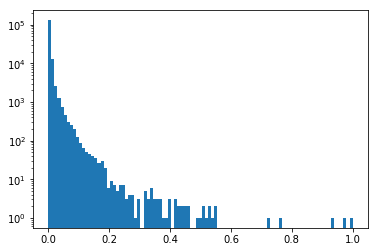

In [428]:
bins=np.linspace(0,1,100)
plt.hist(scores_only_logged.loc[:,'Baseline'],bins=bins,log=True)
plt.show()


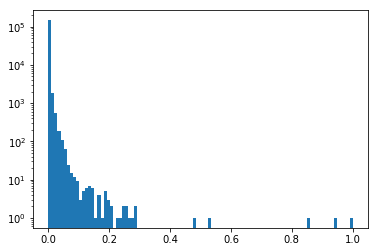

In [429]:
plt.hist(scores_df.loc[:,'Baseline'],bins=bins,log=True)
plt.show()

In [312]:
scores_df = pd.DataFrame({
    "Paper":Q4p.data.dist_score.as_matrix(),
    "Baseline":Q4b.data.dist_score.as_matrix(),
    "PCA90":Q4_pca90.data.dist_score.as_matrix(),
    "PCA95":Q4_pca95.data.dist_score.as_matrix(),
    "PCA99":Q4_pca99.data.dist_score.as_matrix()},
    index=Q4p.data.index)

In [47]:
scores_df['rank_paper']=scores_df.Paper.rank(ascending=False)
scores_df['rank_baseline']=scores_df.Baseline.rank(ascending=False)
scores_df['rank_90']=scores_df.PCA90.rank(ascending=False)
scores_df['rank_95']=scores_df.PCA95.rank(ascending=False)
scores_df['rank_99']=scores_df.PCA99.rank(ascending=False)

In [144]:
scores_df.sort_values(by='rank_90',axis=0)[:10]

,Baseline,PCA90,PCA95,PCA99,Paper,rank_paper,rank_baseline,rank_90,rank_95,rank_99
KID,,,,,,,,,,
kplr007691527,0.958985,1.000000,1.000000,1.000000,0.958985,3.0,3.0,1.0,1.0,1.0
kplr007679979,0.897389,0.843297,0.915862,0.933211,0.897389,4.0,4.0,2.0,2.0,2.0
kplr007446357,1.000000,0.783049,0.801750,0.851316,1.000000,1.0,1.0,3.0,3.0,3.0
kplr007659570,0.972632,0.647217,0.653950,0.792679,0.972632,2.0,2.0,4.0,4.0,4.0
kplr005772512,0.341698,0.569547,0.568416,0.566186,0.341698,6.0,6.0,5.0,6.0,6.0
kplr009098388,0.331419,0.552533,0.551449,0.549281,0.331419,7.0,7.0,6.0,7.0,7.0
kplr009408009,0.255235,0.425760,0.424839,0.422893,0.255235,14.0,14.0,7.0,8.0,10.0
kplr003440230,0.256871,0.403101,0.411814,0.438758,0.256871,12.0,12.0,8.0,11.0,9.0
kplr007033135,0.363232,0.386684,0.598600,0.687319,0.363232,5.0,5.0,9.0,5.0,5.0


Evidently the PCA reduction impacts even the most outlying points somewhat significantly. Which, though, do we interpret to be more representative of the truth?

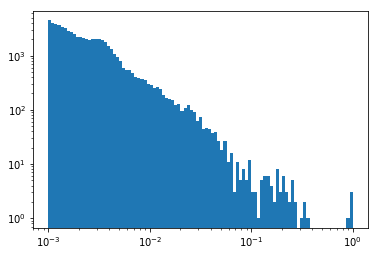

In [219]:
scores = base_qs['Q4'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

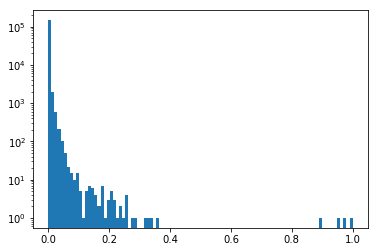

In [223]:
scores = base_qs['Q4'].data.dist_score
bins = np.linspace(0,1,100)
plt.hist(scores, bins=bins, log=True)

plt.show()

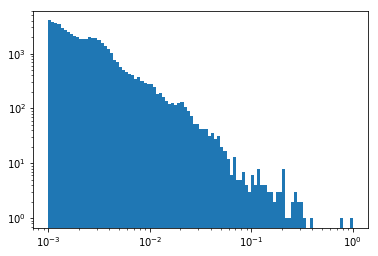

In [220]:
scores = base_qs['Q8'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

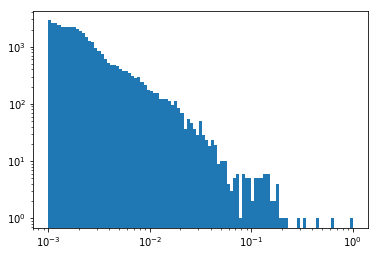

In [221]:
scores = base_qs['Q11'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

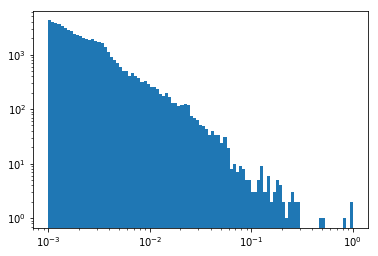

In [222]:
scores = base_qs['Q16'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

## Scoring only outliers

#### Scoring the baseline (unreduced) data

In [73]:
def scoreLoop(qdict):
    startTime = datetime.now()
    scores_dict = dict()
    for Q in adict:
        qStartTime = datetime.now()
        print("Starting {}".format(Q))
        QN = adict[Q]
        data = QN.data
        dims = 0
        for col in data.columns:    
            if col == 'db_out':
                break
            else:
                dims+=1
        print("Scoring {} in {} dimensions".format(Q,dims))
        scaled_data = dataScaler(data,dims)
        out_scores = dist_score(scaled_data,scaled_data[data.db_out==-1])
        scores_dict[Q] = out_scores
        print("Time to process {}: {}".format(Q,datetime.now()-qStartTime))

    print("Time to process all quarters: {}".format(datetime.now()-startTime))
    return scores_dict

In [74]:
adict = base_qs
base_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 60 dimensions
Time to process Q4: 0:00:12.857038
Starting Q8
Scoring Q8 in 60 dimensions
Time to process Q8: 0:00:16.674572
Starting Q11
Scoring Q11 in 60 dimensions
Time to process Q11: 0:00:14.679183
Starting Q16
Scoring Q16 in 60 dimensions
Time to process Q16: 0:00:16.153303
Time to process all quarters: 0:01:00.365658


In [147]:
Q = 'Q16'
df = base_qs[Q].data
out_scores = base_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -161.0, kplr007742133
Greatest rank increase: 21.0, kplr005952324
Median difference in rank: 2.0
Percent w/in 10: 75.0%
Percent w/in 100: 99.87%



In [91]:
adict = pca90_d
pca90_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 18 dimensions
Time to process Q4: 0:00:05.606169
Starting Q8
Scoring Q8 in 18 dimensions
Time to process Q8: 0:00:07.081499
Starting Q11
Scoring Q11 in 17 dimensions
Time to process Q11: 0:00:08.167452
Starting Q16
Scoring Q16 in 17 dimensions
Time to process Q16: 0:00:05.555375
Time to process all quarters: 0:00:26.412719


In [148]:
Q = 'Q16'
df = pca90_d[Q].data
out_scores = pca90_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -181.0, kplr009821923
Greatest rank increase: 18.0, kplr002019352
Median difference in rank: 2.0
Percent w/in 10: 78.8%
Percent w/in 100: 99.91%



In [128]:
adict = pca95_d
pca95_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 23 dimensions
Time to process Q4: 0:00:09.120561
Starting Q8
Scoring Q8 in 24 dimensions
Time to process Q8: 0:00:08.660059
Starting Q11
Scoring Q11 in 22 dimensions
Time to process Q11: 0:00:06.728444
Starting Q16
Scoring Q16 in 23 dimensions
Time to process Q16: 0:00:06.948755
Time to process all quarters: 0:00:31.459481


In [149]:
Q = 'Q16'
df = pca95_d[Q].data
out_scores = pca95_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -116.0, kplr001873918
Greatest rank increase: 15.0, kplr005630212
Median difference in rank: 2.0
Percent w/in 10: 84.2%
Percent w/in 100: 99.91%



In [133]:
adict = pca99_d
pca99_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 35 dimensions
Time to process Q4: 0:00:10.271810
Starting Q8
Scoring Q8 in 36 dimensions
Time to process Q8: 0:00:11.830123
Starting Q11
Scoring Q11 in 34 dimensions
Time to process Q11: 0:00:12.934743
Starting Q16
Scoring Q16 in 34 dimensions
Time to process Q16: 0:00:12.732713
Time to process all quarters: 0:00:47.770770


In [150]:
Q = 'Q16'
df = pca99_d[Q].data
out_scores = pca99_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -104.0, kplr005451040
Greatest rank increase: 17.0, kplr001849235
Median difference in rank: 2.0
Percent w/in 10: 88.7%
Percent w/in 100: 99.98%



### Looking at lightcurves

In [58]:
import quarterTools as qt

In [69]:
def import_generator(suffix='_FullSample.csv'):
    return lambda QN: coo("/home/dgiles/Documents/KeplerLCs/output/"+QN+suffix,"/home/dgiles/Documents/KeplerLCs/fitsFiles/"+QN+"fitsfiles")

In [70]:
# Need the full file names, which are stored in Q*_output.csv

import_quarter = import_generator("_output.csv")

Q4_full = import_quarter('Q4')
Q8_full = import_quarter('Q8')
Q11_full = import_quarter('Q11')
Q16_full = import_quarter('Q16')

In [95]:
FullSample = qt.make_sampler(Q4p.data.index)
Q4_full = FullSample(Q4_full.data.index)
Q8_full = FullSample(Q8_full.data)
Q11_full = FullSample(Q11_full.data)
Q16_full = FullSample(Q16_full.data)

In [96]:
Q4p.data.index = Q4_full.index
Q8p.data.index = Q8_full.index
Q11p.data.index = Q11_full.index
Q16p.data.index = Q16_full.index

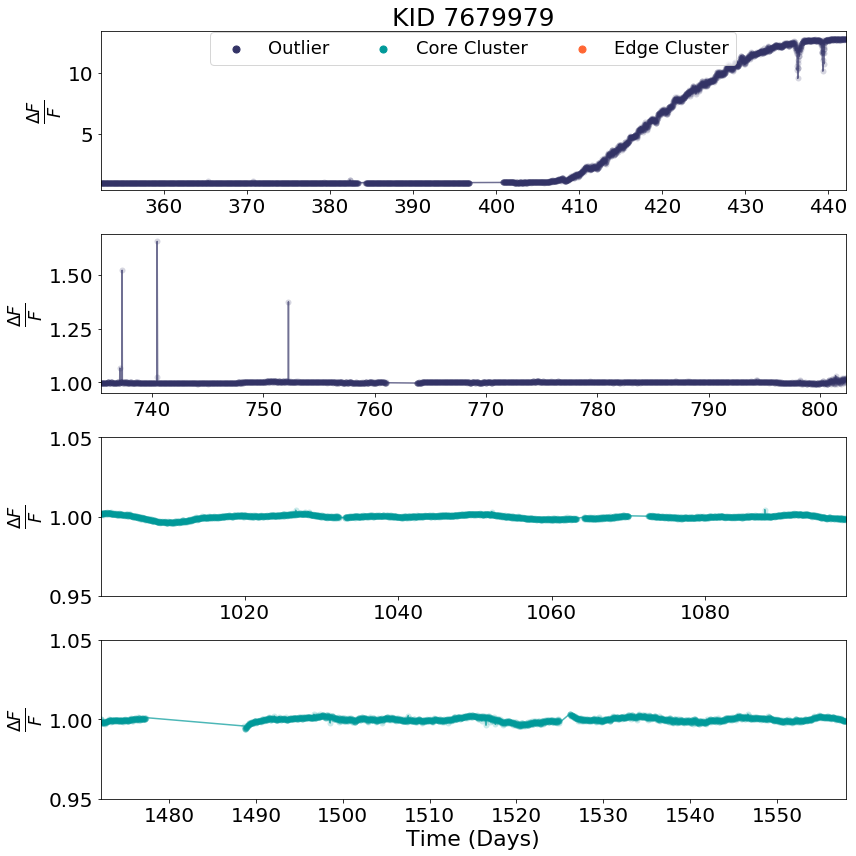

In [145]:
qt.four_Q_lc(scores_df.sort_values(by='rank_paper',axis=0).index[3],Q4p,Q8p,Q11p,Q16p)

In [138]:
def one_Q_lc(kid,Qa):
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(111)
    title_text = 'KID '+str(int(kid[4:13]))
    plt.title(title_text,fontsize=25)
    sampler =  qt.make_sampler([kid])
    QaID = sampler(Qa.data)
    cs = qt.colors_for_plot([QaID.db_out[0]],cmap='color_blind')
    qt.plot_lc(QaID.index[0],filepath=Qa.fitsDir,c=cs[0],ax=ax)
    ax.set_xlabel('Time (Days)',fontsize=22)
    legend_cs = qt.colors_for_plot([0,1,-1],cmap='color_blind')
    ax.scatter([],[],c=legend_cs[-1],s=50,label='Outlier')
    ax.scatter([],[],c=legend_cs[0],s=50,label='Core Cluster')
    ax.scatter([],[],c=legend_cs[1],s=50,label='Edge Cluster')
    ax.legend(loc='upper center',bbox_to_anchor=(0.5,1.05),ncol=3, fontsize=18)

In [153]:
range(0,-10,-1)[1]

-1

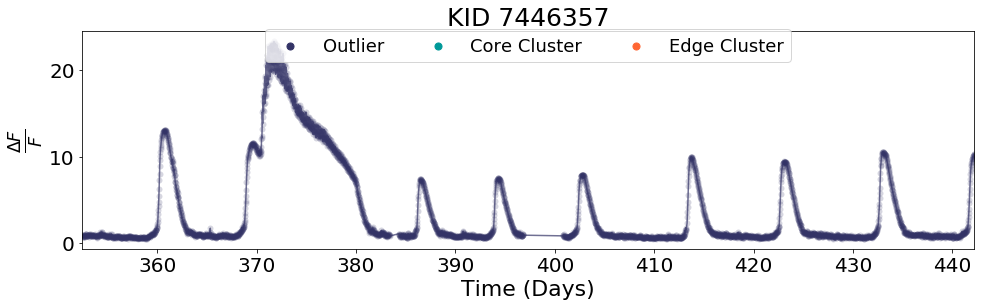

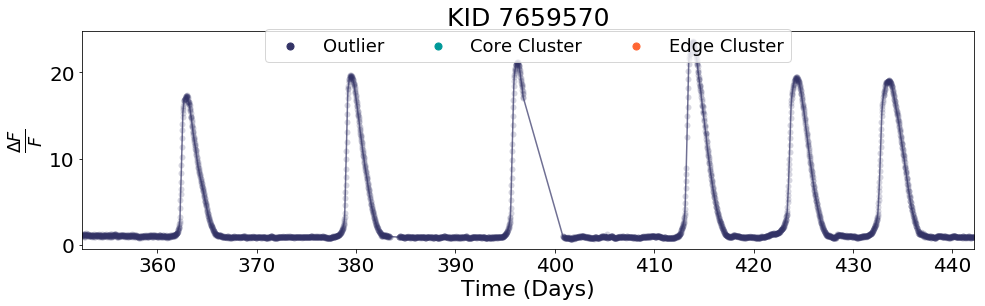

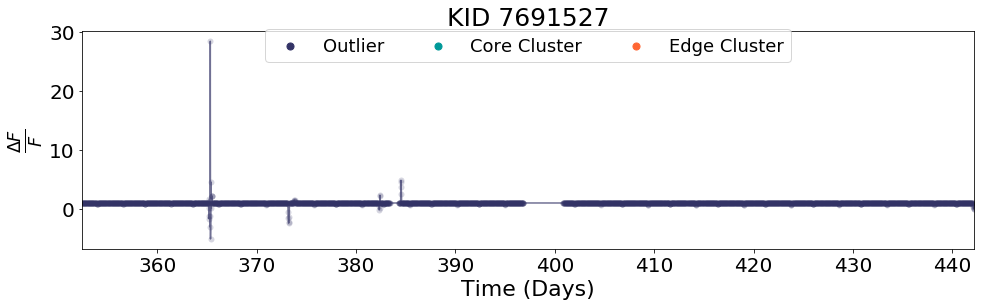

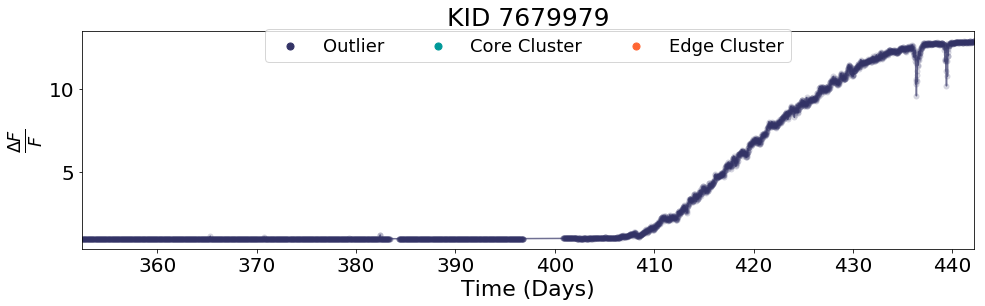

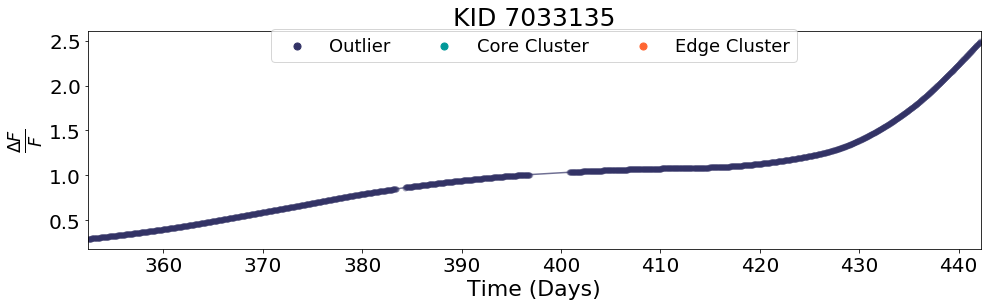

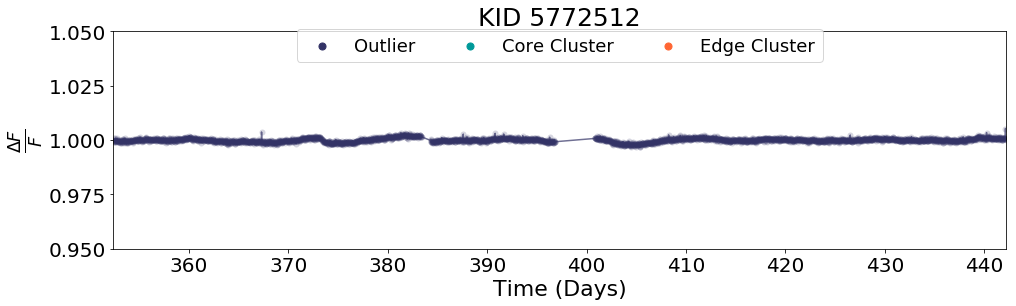

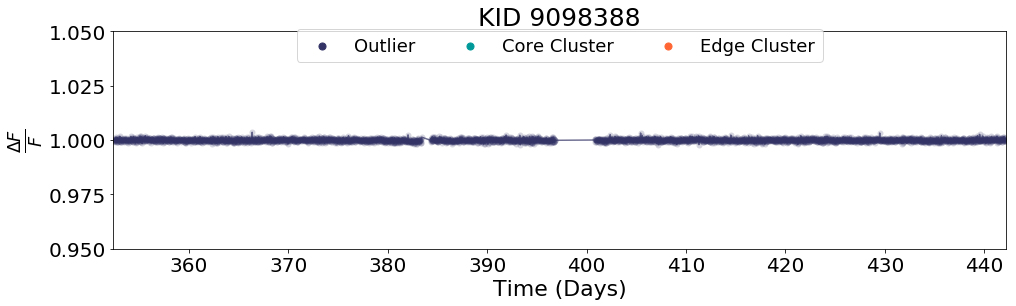

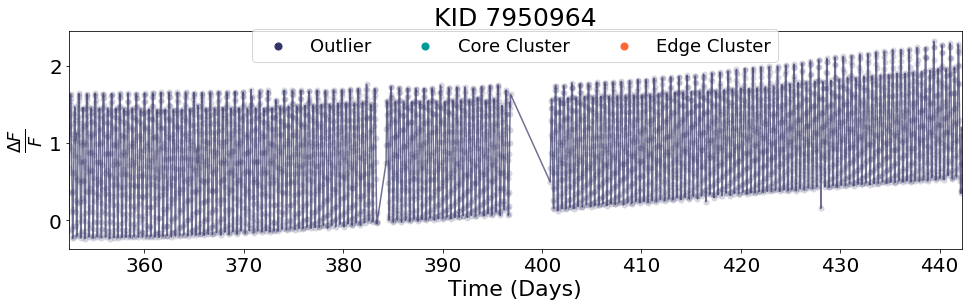

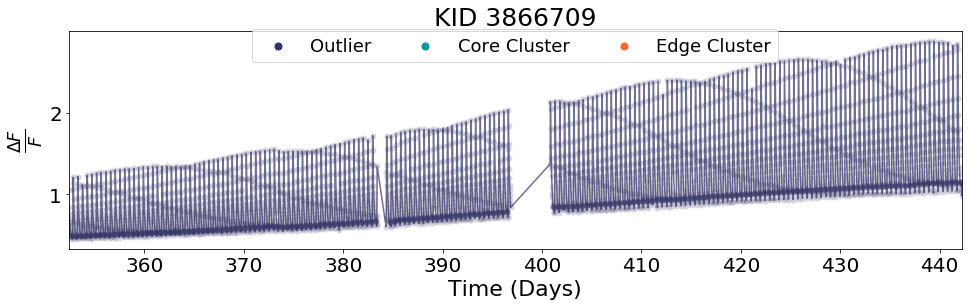

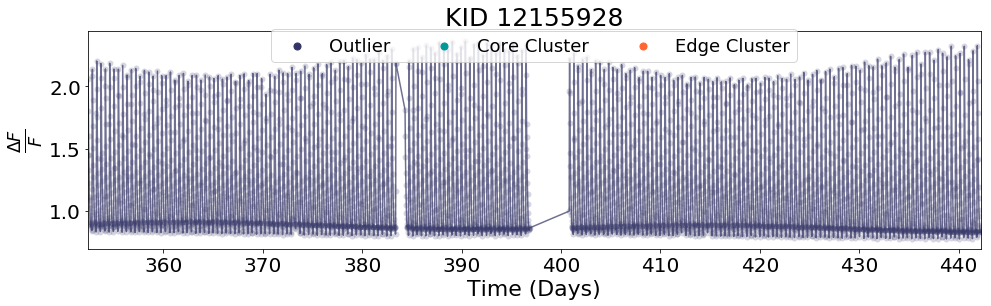

In [202]:
"""
Top 10 outliying lightcurves by baseline score
"""
for i in range(10):
    kid = scores_df.sort_values(by='rank_paper',axis=0).index[i]
    one_Q_lc(kid=kid,Qa=Q4p)


In [9]:
%%timeit
# Only scoring outliers:
startTime = datetime.now()
scaled_data = dataScaler(Q4_pca90.data,18)
out_data = scaled_data[Q4_pca90.data.db_out==-1]
Q4_pca90.out_scores = dist_score(scaled_data,out_data)
print("Time to process: {}".format(datetime.now()-startTime))

Time to process: 0:00:07.226125
Time to process: 0:00:04.924436
Time to process: 0:00:05.032647
Time to process: 0:00:05.042726
Time to process: 0:00:04.951796
Time to process: 0:00:05.492265
Time to process: 0:00:05.650638
Time to process: 0:00:05.619863
5.25 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [214]:
rank_diffs = scores_df.rank_95[Q4p.data.db_out==-1] - scores_df.rank_paper[Q4p.data.db_out==-1]
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:04.2f}%
Percent w/in 1000: {:05.2f}%
Percent w/in 5000: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<1000])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<5000])/len(rank_diffs)*100))


Greatest rank decrease: -1660.0, kplr007122746
Greatest rank increase: 10107.0, kplr008443179
Median difference in rank: -31.0
Percent w/in 10: 02.6%
Percent w/in 100: 22.34%
Percent w/in 1000: 91.80%
Percent w/in 5000: 99.92%



In [192]:
df_tmp = scores_df
df_tmp.index = Q4p.data.index

In [191]:
len(Q_tmp[Q4p.data.db_out==-1])

"""
Issue: Reductions use simplified indices to make comparison across quarters easier (only KIC no timestamp)
This means the data from the paper is not directly comprable.

Solution: Set index of reductions to paper indices here.
"""

'\nIssue: Reductions use simplified indices to make comparison across quarters easier (only KIC no timestamp)\nThis means the data from the paper is not directly comprable.\n\nSolution: Set index of reductions to paper indices here.\n'

In [193]:
pca90_paper_scorediff = df_tmp.PCA90[Q4p.data.db_out==-1] - df_tmp.Paper[Q4p.data.db_out==-1]

print("Min diff: {}, Max diff: {}".format(pca90_paper_scorediff.min(),pca90_paper_scorediff.max()))

Min diff: -0.325414645906953, Max diff: 0.22784832352879897


In [13]:
np.percentile(Q4_pca90.out_scores,90)

0.02660866286119425

Only scoring outliers produces a significant speedup (5s vs 400+s). This does, however, require the prerequisite of already having outliers.

In [117]:
scores = Q4_pca90.data.dist_score[Q4_pca90.data.db_out==-1]
scores = (scores-scores.min())/(scores.max()-scores.min())

In [119]:
score_diff = abs(Q4_pca90.out_scores - scores)
print("""
The absolute maximum difference between scores is {:05.3f}, a {:04.1f}% difference.
""".format(score_diff.max(),score_diff.max()*100))


The absolute maximum difference between scores is 0.002, a 00.2% difference.



In [112]:
score_diff = abs(Q4_pca90.out_scores - Q4_pca90.data.dist_score[Q4_pca90.data.db_out==-1])
print("""
The absolute maximum difference between scores is {:05.3f}, a {:04.1f}% difference.
""".format(score_diff.max(),score_diff.max()*100))


The absolute maximum difference between scores is 0.008, a 00.8% difference.



The difference between scores of the outliers when scoring the whole set versus scoring only the outliers is negligible, producing <1% differences at worst. (1% of the range in which outlier scores are normalized to). The only reason for the difference appears to be where 0 is set.

## Some plots

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

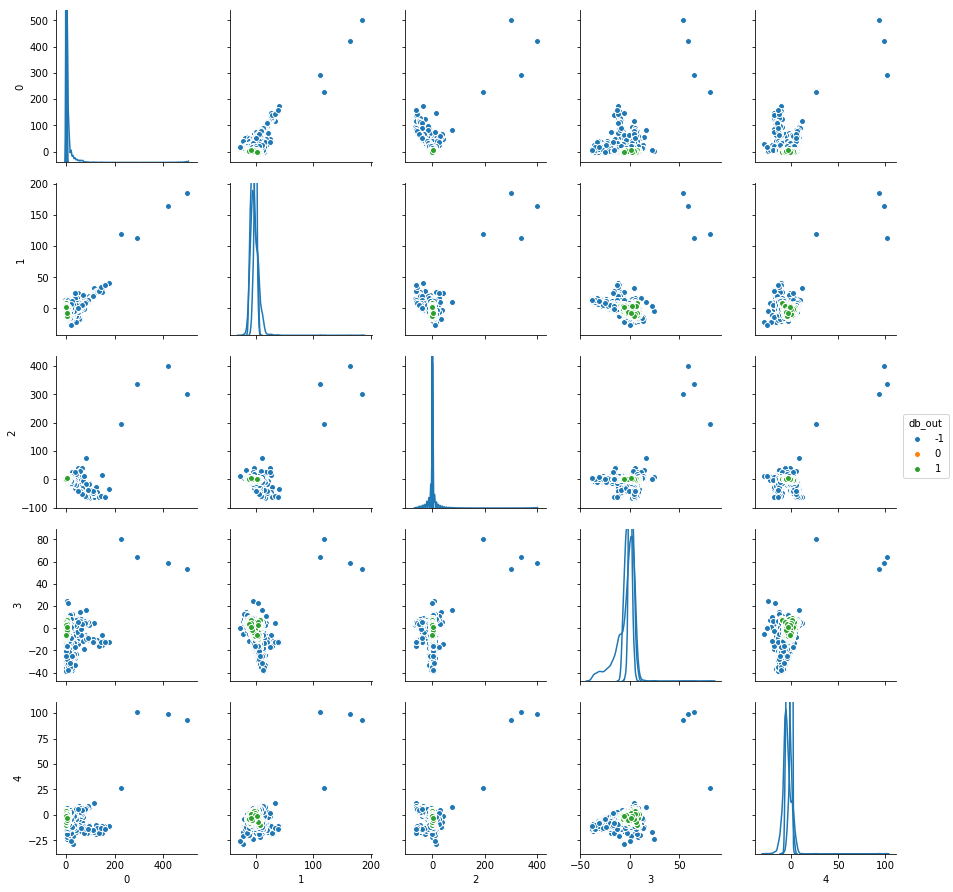

In [213]:
sns.pairplot(Q4_pca90.data,vars=['0','1','2','3','4'],hue='db_out',diag_kind='kde')

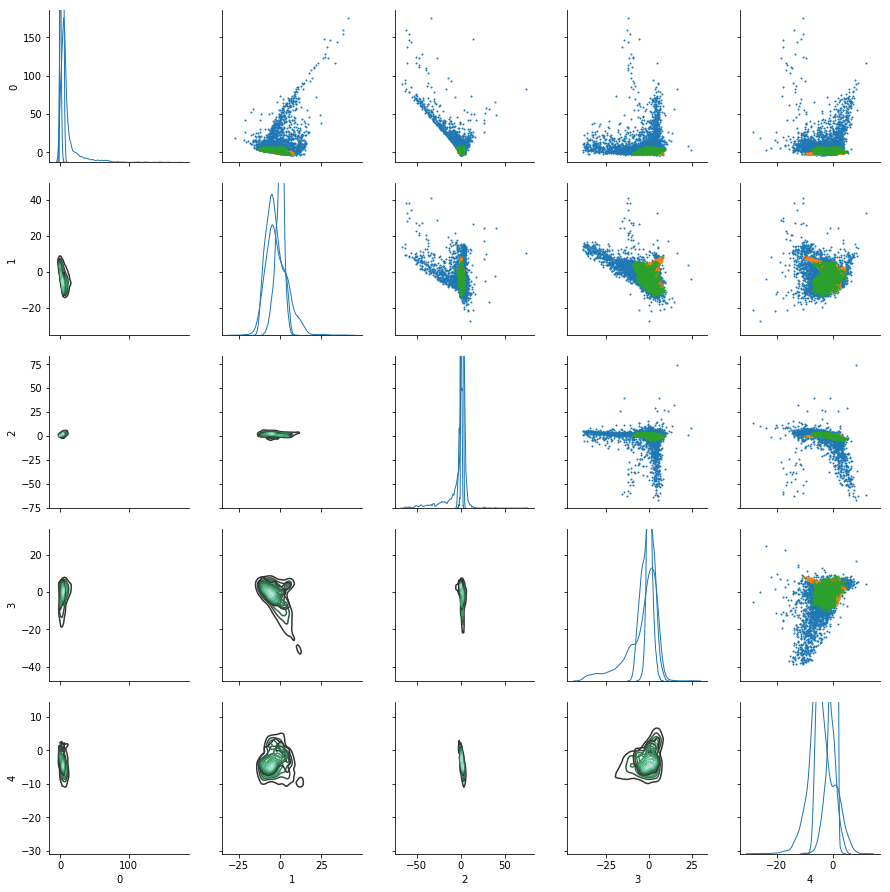

In [215]:
PG = sns.PairGrid(Q4_pca90.data[Q4_pca90.data['1']<75],vars=['0','1','2','3','4'],hue='db_out')
PG.map_lower(sns.kdeplot)
PG.map_upper(plt.scatter, edgecolor=None,s=1)
PG.map_diag(sns.kdeplot, lw=1)

In [216]:
len(scores_df.Paper)

149789

In [ ]:
print('hello')